# Analisis Sentimen Review Toko Baju dengan Deep Learning

Notebook ini berisi implementasi model deep learning untuk menganalisis sentimen dari review toko baju menggunakan TensorFlow. Kita akan mengimplementasikan beberapa model deep learning seperti RNN, LSTM, dan GRU, kemudian membandingkan performanya.

## Tujuan
1. Membangun model deep learning menggunakan TensorFlow untuk analisis sentimen
2. Mengevaluasi model menggunakan metrik: Accuracy, Precision, Recall, F1-score, AUC, ROC
3. Mencapai akurasi minimal 70% pada training dan testing set
4. Membandingkan performa model RNN, LSTM, dan GRU

## 1. Import Library dan Setup Environment

In [15]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

**Penjelasan Cell Import Library**

Pada cell ini, kita mengimpor semua library yang diperlukan untuk implementasi model deep learning:

1. **Library Dasar**:
   - `numpy`: Untuk operasi array dan matriks numerik yang efisien
   - `pandas`: Untuk manipulasi dan analisis data tabel

2. **Library Visualisasi**:
   - `matplotlib.pyplot`: Library plotting dasar untuk visualisasi
   - `seaborn`: Library visualisasi statistik yang dibangun di atas matplotlib

3. **Library Pemrosesan Teks**:
   - `re`: Untuk operasi regex (regular expression) pada teks
   - `string`: Untuk manipulasi string
   - `nltk`: Natural Language Toolkit, untuk pemrosesan bahasa alami
     - `stopwords`: Untuk menghapus kata-kata umum yang tidak memberikan makna
     - `word_tokenize`: Untuk memecah teks menjadi kata-kata
     - `WordNetLemmatizer`: Untuk mengubah kata menjadi bentuk dasarnya

4. **Library Machine Learning**:
   - `sklearn.model_selection`: Untuk membagi dataset
   - `sklearn.metrics`: Untuk metrik evaluasi model

5. **Library Deep Learning**:
   - `tensorflow`: Framework deep learning utama yang kita gunakan
   - Layer-layer Keras untuk membangun model neural network
   - Fungsi untuk preprocessing teks
   - Callbacks untuk monitoring proses training

6. **Library Lainnya**:
   - `time`: Untuk mengukur waktu eksekusi

In [16]:
# Mengecek ketersediaan GPU
print("TensorFlow version:", tf.__version__)
print("GPU tersedia:", len(tf.config.list_physical_devices('GPU')) > 0)

# Download resource NLTK jika belum ada
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

TensorFlow version: 2.18.0
GPU tersedia: True


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Penjelasan Cell Setup Environment**

Cell ini melakukan dua tugas penting untuk persiapan environment:

1. **Pengecekan GPU**
   - Memeriksa versi TensorFlow yang digunakan
   - Mendeteksi ketersediaan GPU pada sistem
   - GPU sangat penting untuk mempercepat proses training model deep learning, terutama untuk dataset besar
   - Jika GPU tersedia, TensorFlow akan secara otomatis menggunakannya

2. **Download Resource NLTK**
   - `punkt`: Package untuk tokenisasi teks menjadi kata-kata
   - `stopwords`: Daftar kata-kata umum (seperti "the", "and", "a") yang biasanya dihapus dalam NLP
   - `wordnet`: Database leksikal yang digunakan untuk lemmatization (mengubah kata menjadi bentuk dasarnya)

Resource NLTK ini diperlukan untuk pemrosesan teks yang akan kita lakukan pada tahap selanjutnya. Tanpa resource ini, fungsi-fungsi NLTK yang kita gunakan akan menimbulkan error.

## 2. Load dan Eksplorasi Dataset

In [17]:
# Load dataset
df = pd.read_csv('ReviewTokoBaju.csv')

# Melihat 5 data pertama
print("5 data pertama:")
display(df.head())

5 data pertama:


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**Penjelasan Cell Load Dataset**

Pada cell ini, kita:
1. Memuat dataset ReviewTokoBaju.csv menggunakan pandas
2. Menampilkan 5 baris pertama dari dataset untuk melihat struktur datanya

Melihat beberapa baris pertama adalah langkah penting untuk memahami struktur dataset, kolom-kolom yang tersedia, dan tipe data yang terkandung di dalamnya. Dari tampilan awal ini, kita dapat mengidentifikasi:
- Kolom yang berisi review teks (`Review Text`)
- Kolom target untuk klasifikasi (`Recommended IND`)
- Kolom-kolom lain seperti `Rating`, `Age`, dll. yang mungkin berguna untuk analisis

Dataset ini berisi review produk pakaian dengan sentimen positif atau negatif, yang akan kita gunakan untuk melatih model deep learning.

In [18]:
# Informasi dataset
print("\nInformasi dataset:")
df.info()

# Statistik deskriptif
print("\nStatistik deskriptif:")
display(df.describe())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB

Statistik deskriptif:


,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


**Penjelasan Cell Informasi Dataset**

Cell ini memberikan informasi lebih detail tentang dataset dengan dua metode:

1. **df.info()**
   - Menampilkan jumlah baris dan kolom dalam dataset
   - Menunjukkan tipe data untuk setiap kolom
   - Menghitung jumlah nilai non-null di setiap kolom, yang membantu mengidentifikasi nilai yang hilang
   - Menampilkan penggunaan memori dataset

2. **df.describe()**
   - Menghasilkan statistik deskriptif untuk kolom numerik
   - Termasuk hitungan, mean, std, min, 25%, 50% (median), 75%, dan max
   - Sangat berguna untuk memahami distribusi data numerik

Informasi ini membantu kita memahami karakteristik dataset, seperti:
- Ukuran dataset (jumlah sampel)
- Kolom mana yang memiliki nilai yang hilang
- Distribusi nilai-nilai numerik (misalnya Rating)
- Rentang usia pengguna
- Berapa banyak review yang direkomendasikan vs tidak direkomendasikan

Pemahaman ini akan memandu kita dalam langkah preprocessing dan pengembangan model selanjutnya.

In [19]:
# Melihat jumlah data untuk setiap nilai Rating
print("\nDistribusi Rating:")
display(df['Rating'].value_counts().sort_index())

# Melihat jumlah data untuk rekomendasi
print("\nDistribusi Recommended IND:")
display(df['Recommended IND'].value_counts())


Distribusi Rating:


,count
Rating,
1,842
2,1565
3,2871
4,5077
5,13131



Distribusi Recommended IND:


,count
Recommended IND,
1,19314
0,4172


**Penjelasan Cell Distribusi Nilai**

Cell ini menganalisis distribusi nilai untuk dua kolom penting dalam dataset: Rating dan Recommended IND.

1. **Distribusi Rating**
   - Menampilkan jumlah review untuk setiap nilai rating (1-5)
   - `sort_index()` memastikan nilai ditampilkan dalam urutan numerik
   - Ini membantu kita memahami apakah dataset seimbang atau didominasi oleh rating tertentu

2. **Distribusi Recommended IND**
   - Menampilkan jumlah review yang direkomendasikan (1) vs tidak direkomendasikan (0)
   - Ini adalah target klasifikasi kita, sehingga penting untuk memahami distribusinya
   - Ketidakseimbangan dalam distribusi target dapat mempengaruhi performa model

Memahami distribusi nilai ini sangat penting karena:
- Dapat mengungkapkan bias dalam dataset (misalnya jika mayoritas review adalah positif)
- Membantu kita memutuskan apakah perlu teknik sampling (oversampling atau undersampling) untuk mengatasi ketidakseimbangan kelas
- Memberikan konteks untuk interpretasi hasil model nanti

Distribusi ini juga akan divisualisasikan pada langkah selanjutnya untuk pemahaman yang lebih intuitif.

## 3. Visualisasi Data

<ipython-input-20-f3e3a3871552>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


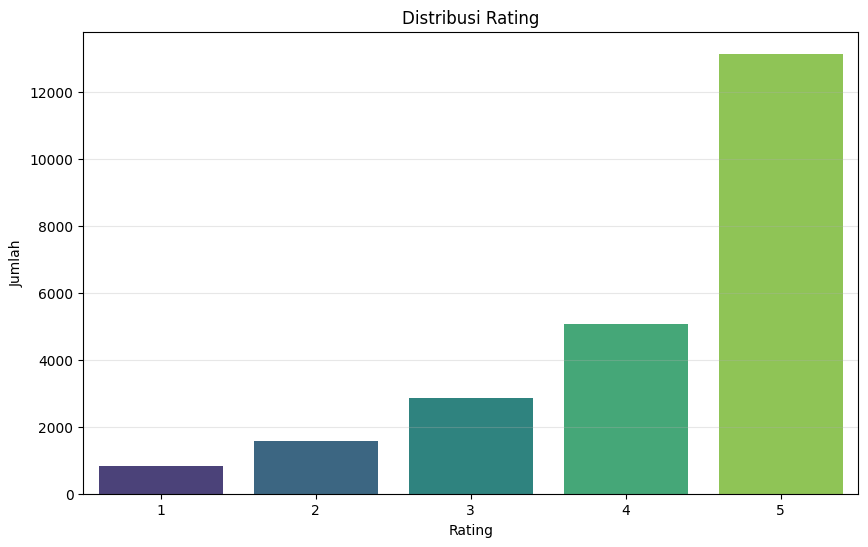

In [20]:
# Visualisasi distribusi Rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.grid(axis='y', alpha=0.3)
plt.show()

**Penjelasan Cell Visualisasi Rating**

Cell ini membuat visualisasi distribusi Rating dalam dataset menggunakan seaborn:

1. **Pembuatan Plot**
   - `plt.figure(figsize=(10, 6))`: Menentukan ukuran figur (lebar 10 inci, tinggi 6 inci)
   - `sns.countplot()`: Membuat bar plot yang menghitung frekuensi setiap nilai rating
   - `palette='viridis'`: Menggunakan colormap viridis yang baik untuk visualisasi kategorikal

2. **Customization Plot**
   - Menambahkan judul, label sumbu x dan y
   - Menambahkan grid horizontal (`axis='y'`) dengan transparansi 0.3 untuk keterbacaan

3. **Interpretasi**
   - Visualisasi ini membantu kita melihat distribusi rating dengan cepat dan intuitif
   - Kita bisa mengidentifikasi apakah rating cenderung positif, negatif, atau seimbang
   - Pola distribusi ini dapat mempengaruhi hasil model, terutama jika terdapat ketidakseimbangan yang signifikan

Visualisasi ini lebih mudah dipahami daripada tabel angka dan membantu kita mendapatkan wawasan cepat tentang data yang kita kerjakan.

<ipython-input-21-31479364b385>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Recommended IND', data=df, palette='Set2')


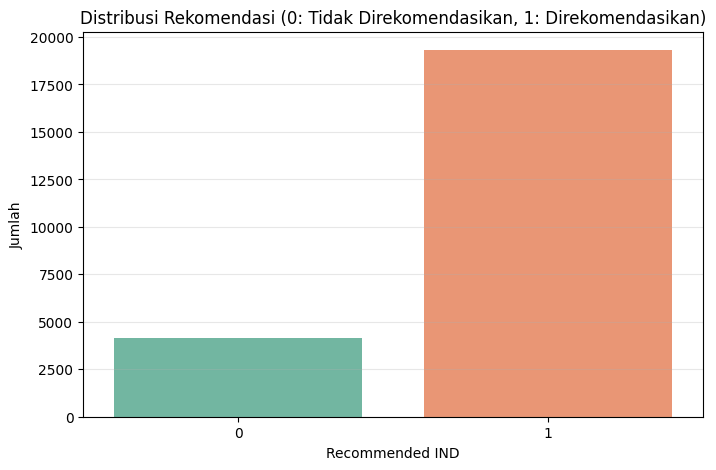

In [21]:
# Visualisasi distribusi Recommended IND
plt.figure(figsize=(8, 5))
sns.countplot(x='Recommended IND', data=df, palette='Set2')
plt.title('Distribusi Rekomendasi (0: Tidak Direkomendasikan, 1: Direkomendasikan)')
plt.xlabel('Recommended IND')
plt.ylabel('Jumlah')
plt.grid(axis='y', alpha=0.3)
plt.show()

**Penjelasan Cell Visualisasi Recommended IND**

Cell ini membuat visualisasi distribusi variabel target 'Recommended IND', yang akan menjadi fokus klasifikasi kita:

1. **Pembuatan Plot**
   - Plot ini menampilkan jumlah review yang direkomendasikan (1) vs tidak direkomendasikan (0)
   - Menggunakan palette warna 'Set2' yang memiliki kontras baik untuk data kategorikal biner

2. **Interpretasi**
   - Variabel ini adalah target klasifikasi biner kita (0 atau 1)
   - Rasio antara kedua kelas sangat penting untuk diperhatikan
   - Jika salah satu kelas sangat dominan (misalnya >90%), kita mungkin menghadapi masalah ketidakseimbangan kelas
   - Ketidakseimbangan kelas dapat menyebabkan model cenderung memprediksi kelas mayoritas

3. **Implikasi**
   - Jika terdapat ketidakseimbangan kelas yang signifikan, kita perlu mempertimbangkan teknik seperti:
     - Oversampling kelas minoritas
     - Undersampling kelas mayoritas
     - Menggunakan class weights dalam model
     - Evaluasi dengan metrik selain akurasi (seperti precision, recall, F1-score)

Visualisasi ini penting karena memahami distribusi target adalah langkah awal untuk strategi pemodelan yang tepat.

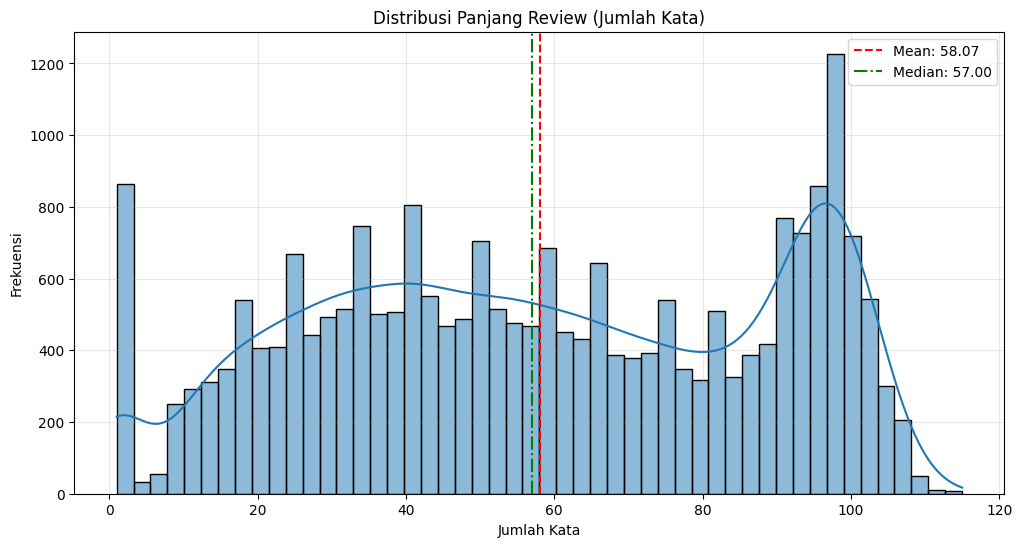

In [22]:
# Visualisasi distribusi panjang review
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['Review Length'], bins=50, kde=True)
plt.title('Distribusi Panjang Review (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.axvline(x=df['Review Length'].mean(), color='r', linestyle='--', label=f'Mean: {df["Review Length"].mean():.2f}')
plt.axvline(x=df['Review Length'].median(), color='g', linestyle='-.', label=f'Median: {df["Review Length"].median():.2f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Penjelasan Cell Distribusi Panjang Review**

Cell ini menganalisis dan memvisualisasikan distribusi panjang review (jumlah kata) dalam dataset:

1. **Perhitungan Panjang Review**
   - Membuat kolom baru 'Review Length' yang menghitung jumlah kata dalam setiap review
   - Menggunakan fungsi lambda dengan `split()` untuk menghitung kata
   - `str(x)` memastikan nilai null dikonversi ke string kosong

2. **Visualisasi Histogram**
   - `sns.histplot()`: Membuat histogram distribusi panjang review
   - `bins=50`: Membagi range data menjadi 50 bin untuk detail yang baik
   - `kde=True`: Menambahkan Kernel Density Estimate untuk estimasi distribusi kontinu

3. **Penambahan Statistik**
   - Garis vertikal merah menunjukkan rata-rata panjang review
   - Garis vertikal hijau menunjukkan median panjang review
   - Legend menampilkan nilai numerik dari rata-rata dan median

4. **Implikasi untuk Model**
   - Distribusi ini membantu menentukan parameter `max_length` untuk padding sequence
   - Jika mayoritas review pendek tapi ada beberapa yang sangat panjang, kita perlu strategi padding yang tepat
   - Terlalu banyak padding dapat membuang-buang memori, terlalu sedikit dapat menghilangkan informasi
   - Perbedaan signifikan antara mean dan median menunjukkan distribusi yang miring

Memahami distribusi panjang teks sangat penting dalam NLP karena mempengaruhi preprocessing dan arsitektur model yang optimal.

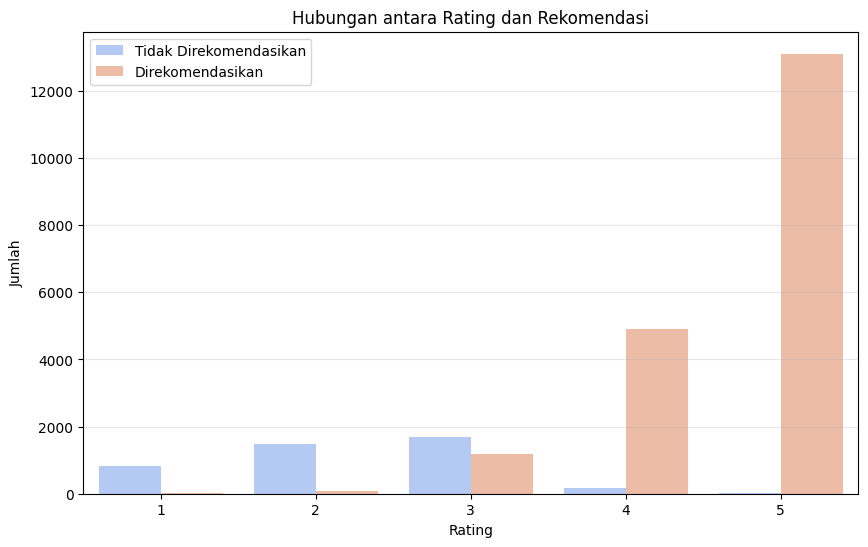

In [23]:
# Visualisasi hubungan antara Rating dan Recommended IND
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Recommended IND', data=df, palette='coolwarm')
plt.title('Hubungan antara Rating dan Rekomendasi')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.legend(['Tidak Direkomendasikan', 'Direkomendasikan'])
plt.grid(axis='y', alpha=0.3)
plt.show()

**Penjelasan Cell Hubungan Rating dan Recommended IND**

Cell ini menganalisis dan memvisualisasikan hubungan antara Rating dan variabel target Recommended IND:

1. **Visualisasi Countplot dengan Pengelompokan**
   - `sns.countplot()` dengan parameter `hue='Recommended IND'` untuk memisahkan warna berdasarkan rekomendasi
   - `palette='coolwarm'` memberikan palette warna yang kontras (biasanya biru untuk nilai rendah, merah untuk nilai tinggi)

2. **Interpretasi**
   - Plot ini menunjukkan bagaimana kecenderungan rekomendasi berubah berdasarkan rating
   - Umumnya, rating tinggi (4-5) cenderung direkomendasikan, rating rendah (1-2) cenderung tidak direkomendasikan
   - Rating menengah (3) mungkin memiliki campuran rekomendasi yang menarik untuk dianalisis

3. **Wawasan Bisnis**
   - Mungkin ada pola-pola yang tidak intuitif (misalnya, beberapa review dengan rating rendah tetap direkomendasikan)
   - Eksplorasi lebih lanjut dalam pola ini dapat memberikan wawasan bisnis

4. **Implikasi untuk Model**
   - Jika korelasi antara Rating dan Recommended IND sangat tinggi, Rating bisa menjadi fitur yang kuat
   - Jika terdapat pola yang kompleks, ini menunjukkan pentingnya analisis teks (Review Text) untuk memprediksi rekomendasi

Visualisasi ini membantu kita memahami keterkaitan antara rating numerik dan keputusan rekomendasi, yang dapat memberi konteks untuk interpretasi model kita nanti.

## 4. Preprocessing Data

In [24]:
# Memeriksa nilai yang hilang
print("Jumlah nilai hilang per kolom:")
print(df.isnull().sum())

Jumlah nilai hilang per kolom:
Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
Review Length                 0
dtype: int64


**Penjelasan Cell Pengecekan Nilai Hilang**

Cell ini memeriksa ada tidaknya nilai hilang (missing values/NaN) dalam dataset:

1. **Metode Pengecekan**
   - `df.isnull().sum()` menghitung jumlah nilai null dalam setiap kolom
   - Ini adalah langkah penting sebelum preprocessing untuk menghindari error

2. **Interpretasi**
   - Jika terdapat nilai null dalam kolom penting seperti 'Review Text' atau 'Recommended IND', kita perlu strategi penanganan
   - Nilai null dalam 'Review Text' bisa diisi dengan string kosong atau dihapus
   - Nilai null dalam target ('Recommended IND') biasanya lebih baik dihapus daripada diimputasi

3. **Implikasi**
   - Nilai yang hilang dapat menyebabkan bias dalam model
   - Strategi penanganan nilai hilang harus mempertimbangkan dampaknya pada distribusi data
   - Dokumentasi jelas tentang penanganan nilai hilang penting untuk reproduksibilitas

Pengecekan dan penanganan nilai hilang adalah langkah preprocessing dasar yang penting untuk memastikan kualitas data input model.

In [25]:
# Menangani nilai yang hilang pada kolom 'Review Text'
df['Review Text'] = df['Review Text'].fillna('')

# Menampilkan jumlah review kosong setelah penanganan
empty_reviews = (df['Review Text'] == '').sum()
print(f"Jumlah review kosong setelah penanganan: {empty_reviews}")

Jumlah review kosong setelah penanganan: 845


**Penjelasan Cell Penanganan Nilai Hilang**

Cell ini menangani nilai hilang pada kolom 'Review Text' yang merupakan fitur utama untuk model kita:

1. **Metode Penanganan**
   - `fillna('')` mengisi semua nilai NaN dengan string kosong
   - Ini adalah pendekatan sederhana untuk menangani nilai hilang dalam teks

2. **Verifikasi**
   - Menghitung jumlah review yang kosong setelah penanganan
   - Ini termasuk review yang awalnya NaN dan kini menjadi string kosong

3. **Alternatif Penanganan**
   - Alternatif lain adalah menghapus baris dengan review kosong (`df.dropna(subset=['Review Text'])`)
   - Kita memilih mengisi dengan string kosong untuk mempertahankan jumlah data
   - Review kosong akan diproses sebagai sequence kosong oleh model

4. **Implikasi**
   - Review kosong mungkin memiliki informasi implisit (misalnya, pelanggan tidak memiliki banyak yang dikatakan)
   - Model harus dapat menangani input kosong dengan baik

Penanganan nilai hilang ini memastikan tidak ada error saat preprocessing teks, sambil mempertahankan sebanyak mungkin data untuk training.

In [26]:
# Definisi fungsi untuk membersihkan teks
def clean_text(text):
    # Mengubah ke huruf kecil
    text = text.lower()

    # Menghapus HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Menghapus angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Menghapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

**Penjelasan Cell Fungsi Clean Text**

Cell ini mendefinisikan fungsi `clean_text()` untuk membersihkan teks review. Preprocessing teks adalah langkah krusial dalam NLP yang dapat sangat mempengaruhi performa model:

1. **Konversi ke Huruf Kecil**
   - `text = text.lower()` mengubah semua teks menjadi huruf kecil
   - Ini mengurangi dimensi vocabulary karena kata-kata seperti "Good", "good", dan "GOOD" diperlakukan sama

2. **Menghapus HTML Tags**
   - `re.sub(r'<.*?>', '', text)` menghapus tag HTML seperti `<br>` atau `<p>`
   - Penting karena review sering mengandung formatting HTML yang tidak relevan

3. **Menghapus URL**
   - Menggunakan regex untuk menghapus URL yang dimulai dengan http, https, atau www
   - URL biasanya tidak memberikan kontribusi untuk analisis sentimen

4. **Menghapus Angka dan Tanda Baca**
   - `re.sub(r'\d+', '', text)` menghapus semua angka
   - `text.translate(str.maketrans('', '', string.punctuation))` menghapus semua tanda baca
   - Tanda baca dan angka sering kali tidak penting untuk analisis sentimen

5. **Menghapus Whitespace Berlebih**
   - `re.sub(r'\s+', ' ', text).strip()` mengubah multiple whitespace menjadi satu spasi
   - `.strip()` menghapus whitespace di awal dan akhir teks

Fungsi ini memastikan teks menjadi bersih dan standar sebelum diproses lebih lanjut, yang meningkatkan kualitas fitur untuk model.

In [27]:
# Fungsi untuk lemmatization (mengubah kata ke bentuk dasar)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Membersihkan teks
    text = clean_text(text)

    # Tokenisasi
    tokens = word_tokenize(text)

    # Menghapus stopwords dan lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

**Penjelasan Cell Fungsi Preprocess Text**

Cell ini mendefinisikan fungsi `preprocess_text()` yang melakukan preprocessing lebih lanjut pada teks dengan teknik NLP yang lebih canggih:

1. **Inisialisasi Tools NLP**
   - `WordNetLemmatizer()`: Tool untuk mengubah kata ke bentuk dasarnya
   - `stopwords.words('english')`: Daftar kata-kata umum dalam bahasa Inggris yang umumnya tidak membawa makna signifikan

2. **Langkah Preprocessing**
   - **Cleaning**: Memanggil fungsi `clean_text()` yang didefinisikan sebelumnya
   - **Tokenisasi**: Memecah teks menjadi tokens (kata-kata individual) menggunakan `word_tokenize()`
   - **Menghapus Stopwords**: Menyaring kata-kata umum seperti "the", "and", "is" yang biasanya tidak berkontribusi pada sentimen
   - **Lemmatization**: Mengubah kata ke bentuk dasarnya menggunakan `lemmatizer.lemmatize()`
     - Contoh: "running" → "run", "better" → "good"
     - Berbeda dengan stemming yang hanya memotong akhiran, lemmatization mempertimbangkan konteks linguistik

3. **Penggabungan Kembali**
   - Menggabungkan tokens kembali menjadi string dengan `' '.join(tokens)`

4. **Keunggulan Teknik Ini**
   - **Mengurangi Dimensi**: Mengurangi jumlah kata unik dalam vocabulary
   - **Normalisasi**: Menyederhanakan kata-kata ke bentuk standar
   - **Fokus pada Konten**: Menghapus kata-kata yang tidak berkontribusi signifikan
   - **Meningkatkan Efisiensi**: Model dapat belajar dari fitur yang lebih sederhana dan bermakna

Fungsi ini adalah bagian kunci dari pipeline preprocessing NLP yang akan membantu model fokus pada kata-kata yang paling relevan untuk analisis sentimen.

In [28]:
# Menerapkan preprocessing ke kolom 'Review Text'
print("Melakukan preprocessing teks...")
df['Processed_Review'] = df['Review Text'].apply(preprocess_text)
print("Preprocessing selesai!")

# Menampilkan contoh review sebelum dan sesudah preprocessing
print("\nContoh review sebelum dan sesudah preprocessing:")
for i in range(3):
    print(f"\nReview ke-{i+1}:")
    print(f"Sebelum: {df['Review Text'].iloc[i][:100]}...")
    print(f"Sesudah: {df['Processed_Review'].iloc[i][:100]}...")

Melakukan preprocessing teks...
Preprocessing selesai!

Contoh review sebelum dan sesudah preprocessing:

Review ke-1:
Sebelum: Absolutely wonderful - silky and sexy and comfortable...
Sesudah: absolutely wonderful silky sexy comfortable...

Review ke-2:
Sebelum: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never...
Sesudah: love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought pe...

Review ke-3:
Sebelum: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the pe...
Sesudah: high hope dress really wanted work initially ordered petite small usual size found outrageously smal...


**Penjelasan Cell Penerapan Preprocessing**

Cell ini menerapkan fungsi preprocessing yang telah didefinisikan ke seluruh dataset dan menampilkan contoh hasilnya:

1. **Aplikasi Preprocessing**
   - `df['Processed_Review'] = df['Review Text'].apply(preprocess_text)` menerapkan fungsi preprocessing ke setiap review
   - Membuat kolom baru 'Processed_Review' untuk menyimpan hasil preprocessing
   - Menyimpan hasil dalam kolom baru memungkinkan kita membandingkan teks asli dan hasil preprocessing

2. **Progress Logging**
   - Pesan "Melakukan preprocessing teks..." dan "Preprocessing selesai!" membantu melacak progress
   - Preprocessing teks pada dataset besar bisa memakan waktu lama

3. **Menampilkan Contoh**
   - Menampilkan 3 contoh review sebelum dan sesudah preprocessing
   - Ini membantu memverifikasi bahwa preprocessing berfungsi seperti yang diharapkan
   - Hanya menampilkan 100 karakter pertama untuk keterbacaan

4. **Perubahan yang Diharapkan**
   - Huruf kapital menjadi huruf kecil
   - HTML tags, URLs, angka, dan tanda baca dihapus
   - Stopwords dihapus
   - Kata-kata diubah ke bentuk dasarnya
   - Whitespace berlebih dihapus

Langkah ini sangat penting karena kualitas preprocessing teks secara langsung mempengaruhi kemampuan model untuk mengekstrak pola dan hubungan yang bermakna dari data.

## 5. Persiapan Fitur dan Target

In [29]:
# Mendefinisikan fitur (X) dan target (y)
X = df['Processed_Review'].values
y = df['Recommended IND'].values

# Pembagian data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

Jumlah data training: 18788
Jumlah data testing: 4698


**Penjelasan Cell Persiapan dan Pembagian Data**

Cell ini mempersiapkan fitur dan target untuk model, serta membagi dataset menjadi training dan testing set:

1. **Definisi Fitur dan Target**
   - **Fitur (X)**: Review yang telah diproses (`Processed_Review`)
     - Menggunakan `.values` untuk mengkonversi dari pandas Series menjadi numpy array
   - **Target (y)**: Variabel `Recommended IND` yang bernilai 0 atau 1
     - 0: Tidak direkomendasikan
     - 1: Direkomendasikan

2. **Pembagian Dataset**
   - Menggunakan `train_test_split` dari scikit-learn untuk membagi data
   - **test_size=0.2**: 80% data untuk training, 20% untuk testing
   - **random_state=42**: Menetapkan seed untuk reproduksibilitas
   - **stratify=y**: Memastikan proporsi kelas dalam target (0 dan 1) tetap sama di kedua set
     - Penting untuk mencegah distribusi yang tidak seimbang antara training dan testing

3. **Verifikasi Pembagian**
   - Mencetak jumlah data di masing-masing set untuk memastikan pembagian sesuai harapan

4. **Implikasi**
   - Training set digunakan untuk melatih model
   - Testing set disimpan untuk evaluasi final model
   - Stratifikasi berdasarkan y memastikan model dilatih dan dievaluasi pada distribusi kelas yang konsisten

Pembagian data yang baik sangat penting untuk evaluasi model yang valid. Stratifikasi memastikan bahwa proporsi kelas tetap konsisten, yang penting terutama jika kelas tidak seimbang.

In [30]:
# Tokenisasi teks
max_features = 10000  # Jumlah maksimum kata dalam vocabulary
max_length = 100  # Panjang maksimum sequence

# Membuat tokenizer
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Mengubah teks menjadi sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Melihat ukuran vocabulary dan contoh sequence
print(f"Ukuran vocabulary: {len(tokenizer.word_index) + 1}")
print(f"Contoh 5 kata pertama dalam vocabulary: {list(tokenizer.word_index.items())[:5]}")
print(f"Contoh sequence dari review pertama: {X_train_seq[0][:10]}...")

Ukuran vocabulary: 14979
Contoh 5 kata pertama dalam vocabulary: [('<OOV>', 1), ('dress', 2), ('fit', 3), ('size', 4), ('love', 5)]
Contoh sequence dari review pertama: [472, 194, 1398, 498, 17, 6915, 15, 541, 169, 17]...


**Penjelasan Cell Tokenisasi Teks**

Cell ini mengubah teks review yang telah diproses menjadi representasi numerik yang dapat digunakan oleh model deep learning:

1. **Pengaturan Parameter**
   - **max_features=10000**: Membatasi vocabulary hanya ke 10,000 kata yang paling sering muncul
     - Mengurangi dimensi input dan mencegah overfitting
     - Menghilangkan kata-kata yang sangat jarang yang mungkin hanya noise
   - **max_length=100**: Panjang maksimum sequence yang akan diproses
     - Berdasarkan analisis distribusi panjang review sebelumnya

2. **Tokenisasi**
   - `Tokenizer`: Class dari Keras untuk mengubah teks menjadi sequence angka
   - **num_words=max_features**: Membatasi vocabulary ke max_features kata terbanyak
   - **oov_token='<OOV>'**: Token untuk kata-kata Out-of-Vocabulary (tidak ada dalam vocabulary)
   - **fit_on_texts(X_train)**: Membangun vocabulary hanya dari data training
     - PENTING: Vocabulary hanya dibuat dari training data untuk mencegah data leakage

3. **Konversi Teks ke Sequence**
   - `texts_to_sequences()`: Mengubah setiap review menjadi sequence angka
     - Setiap angka mewakili indeks kata dalam vocabulary
     - Kata-kata yang tidak ada dalam vocabulary (karena berada di luar max_features atau hanya ada di test set) diganti dengan token OOV

4. **Verifikasi**
   - Mencetak ukuran vocabulary (jumlah kata unik + 1 untuk padding index 0)
   - Menampilkan beberapa kata pertama dalam vocabulary beserta indeksnya
   - Menampilkan contoh sequence dari review pertama

Tokenisasi adalah langkah penting dalam NLP karena model neural network hanya dapat memproses angka, bukan teks. Langkah ini mengubah kata-kata menjadi indeks dalam vocabulary yang konsisten.

In [31]:
# Padding sequence agar memiliki panjang yang sama
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Melihat bentuk data setelah padding
print(f"Bentuk data training setelah padding: {X_train_pad.shape}")
print(f"Bentuk data testing setelah padding: {X_test_pad.shape}")

# Melihat contoh sequence setelah padding
print("\nContoh sequence setelah padding:")
print(X_train_pad[0])

Bentuk data training setelah padding: (18788, 100)
Bentuk data testing setelah padding: (4698, 100)

Contoh sequence setelah padding:
[ 472  194 1398  498   17 6915   15  541  169   17 6916 2619   20  404
  284  151  238   10 4427  535  296   84    8  138  328  956  308  373
    5   31   22  352   25   21   69  338  289  311  135  976  614 1237
  253    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


**Penjelasan Cell Padding Sequence**

Cell ini melakukan padding pada sequence untuk memastikan semua input memiliki panjang yang sama, yang diperlukan untuk model neural network:

1. **Kebutuhan Padding**
   - Model neural network membutuhkan input dengan dimensi yang seragam
   - Namun, review memiliki panjang yang bervariasi
   - Padding menyeragamkan panjang semua sequence ke `max_length`

2. **Fungsi Padding**
   - `pad_sequences()`: Fungsi Keras untuk padding sequence
   - **maxlen=max_length**: Menetapkan panjang maksimum sequence (100 dalam kasus ini)
   - **padding='post'**: Menambahkan padding (nilai 0) di akhir sequence
     - Alternatifnya adalah 'pre' yang menambahkan di awal
     - 'post' lebih cocok karena informasi penting biasanya di awal teks
   - **truncating='post'**: Memotong sequence yang terlalu panjang dari akhir
     - Ini mempertahankan kata-kata awal yang sering lebih penting

3. **Hasil Padding**
   - Setiap sample sekarang berbentuk array dengan panjang yang sama (max_length)
   - Sequence pendek diisi dengan nilai 0 di akhir
   - Sequence panjang dipotong ke max_length

4. **Verifikasi**
   - Memeriksa bentuk (shape) array hasil padding
   - Menampilkan contoh sequence setelah padding
   - Dalam contoh, banyak 0 di akhir menunjukkan sequence asli lebih pendek dari max_length

Padding adalah langkah preprocessing penting yang membuat data teks siap untuk diproses oleh model deep learning. Pilihan padding dan truncating dapat mempengaruhi performa model, terutama untuk teks dengan panjang yang sangat bervariasi.

## 6. Fungsi Evaluasi Model

In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Fungsi untuk mengevaluasi model menggunakan berbagai metrik"""

    # Prediksi probabilitas
    y_train_pred_proba = model.predict(X_train)
    y_test_pred_proba = model.predict(X_test)

    # Prediksi kelas (threshold 0.5)
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Evaluasi pada training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Evaluasi pada testing set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Print hasil evaluasi
    print(f"\n==== Evaluasi Model {model_name} ====")
    print("\nMetrik pada Training Set:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-score: {train_f1:.4f}")
    print(f"AUC: {train_auc:.4f}")

    print("\nMetrik pada Testing Set:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1-score: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")

    # Classification report
    print("\nClassification Report (Testing Set):")
    print(classification_report(y_test, y_test_pred))

    # Return semua hasil evaluasi dalam bentuk dictionary
    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'train_auc': train_auc,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'y_test_pred': y_test_pred,
        'y_test_pred_proba': y_test_pred_proba
    }

**Penjelasan Cell Fungsi Evaluasi Model**

Cell ini mendefinisikan fungsi komprehensif untuk mengevaluasi model dengan berbagai metrik yang diperlukan. Evaluasi yang baik sangat penting untuk memahami performa model secara menyeluruh:

1. **Parameter Fungsi**
   - **model**: Model yang telah dilatih
   - **X_train, y_train**: Data training untuk evaluasi
   - **X_test, y_test**: Data testing untuk evaluasi
   - **model_name**: Nama model untuk pelaporan

2. **Prediksi**
   - **Prediksi Probabilitas**: `model.predict()` menghasilkan probabilitas kelas positif (0-1)
   - **Prediksi Kelas**: Mengkonversi probabilitas menjadi label (0/1) dengan threshold 0.5
     - Formula: `(probabilitas > 0.5).astype(int)`

3. **Metrik Evaluasi**
   - **Accuracy**: Proporsi prediksi yang benar dari total prediksi
     - Formula: $(TP + TN) / (TP + TN + FP + FN)$
   - **Precision**: Proporsi prediksi positif yang benar
     - Formula: $TP / (TP + FP)$
     - Mengukur *seberapa akurat* prediksi positif model
   - **Recall**: Proporsi sampel positif yang teridentifikasi dengan benar
     - Formula: $TP / (TP + FN)$
     - Mengukur *seberapa lengkap* model mengidentifikasi kelas positif
   - **F1-score**: Rata-rata harmonik dari precision dan recall
     - Formula: $2 * (Precision * Recall) / (Precision + Recall)$
     - Menyeimbangkan precision dan recall
   - **AUC**: Area Under the ROC Curve
     - Mengukur kemampuan model membedakan kelas
     - Nilai 0.5 berarti performa acak, nilai 1.0 berarti sempurna

4. **Classification Report**
   - Laporan lengkap dari scikit-learn yang menampilkan precision, recall, dan F1-score untuk setiap kelas

5. **Return**
   - Mengembalikan semua metrik dalam dictionary untuk penggunaan selanjutnya
   - Berguna untuk perbandingan antar model

Fungsi ini akan memberikan pandangan menyeluruh tentang performa model, tidak hanya pada satu metrik. Ini penting karena metrik tunggal (seperti accuracy) bisa menyesatkan, terutama pada dataset yang tidak seimbang.

In [33]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Fungsi untuk membuat plot confusion matrix"""

    # Menghitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Membuat plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Menghitung dan menampilkan metrik tambahan
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-score: {f1:.4f}")

**Penjelasan Cell Fungsi Plot Confusion Matrix**

Cell ini mendefinisikan fungsi untuk membuat dan memvisualisasikan confusion matrix, yang merupakan alat penting untuk memahami jenis kesalahan yang dibuat model:

1. **Apa itu Confusion Matrix?**
   - Tabel yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas
   - Untuk klasifikasi biner, berisi 4 nilai: True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)

2. **Pembuatan Confusion Matrix**
   - `confusion_matrix()` dari scikit-learn menghitung matrix berdasarkan label sebenarnya dan prediksi
   - Visualisasi dengan heatmap seaborn membuat matrix lebih mudah dibaca
   - `annot=True` menampilkan nilai numerik di setiap cell
   - `cmap='Blues'` memberikan gradient warna biru (lebih gelap = nilai lebih tinggi)

3. **Metrik yang Dihitung dari Confusion Matrix**
   - `cm.ravel()` mengekstrak empat nilai (TN, FP, FN, TP) dari matrix 2x2
   - **Accuracy**: (TP + TN) / (TP + TN + FP + FN)
   - **Precision**: TP / (TP + FP)
   - **Recall/Sensitivity**: TP / (TP + FN)
   - **Specificity**: TN / (TN + FP)
     - Mengukur kemampuan model mengidentifikasi kelas negatif dengan benar
   - **F1-score**: 2 * (Precision * Recall) / (Precision + Recall)

4. **Keunggulan Confusion Matrix**
   - Memberikan gambaran lengkap tentang performa model
   - Memungkinkan analisis jenis kesalahan spesifik (FP vs FN)
   - Berguna untuk masalah dengan biaya kesalahan yang tidak simetris
     - Misalnya, FN mungkin lebih mahal dari FP atau sebaliknya

Confusion matrix adalah alat visualisasi yang kuat untuk memahami nuansa performa model klasifikasi, terutama ketika metrik seperti accuracy saja tidak cukup informatif.

In [34]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    """Fungsi untuk membuat plot ROC curve"""

    # Menghitung ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Membuat plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # Menampilkan AUC
    print(f"AUC (Area Under the ROC Curve): {roc_auc:.4f}")

    # Mengembalikan nilai untuk penggunaan selanjutnya
    return fpr, tpr, roc_auc

**Penjelasan Cell Fungsi Plot ROC Curve**

Cell ini mendefinisikan fungsi untuk membuat dan memvisualisasikan ROC Curve, yang merupakan alat penting untuk mengevaluasi model klasifikasi pada berbagai threshold:

1. **Apa itu ROC Curve?**
   - **ROC (Receiver Operating Characteristic)** adalah plot yang menampilkan True Positive Rate (TPR) vs False Positive Rate (FPR) pada berbagai threshold
   - Memvisualisasikan trade-off antara sensitivitas (recall) dan spesifisitas

2. **Komponen ROC Curve**
   - **False Positive Rate (FPR)**: FP / (FP + TN) = 1 - Specificity
     - Proporsi sampel negatif yang keliru diprediksi positif
   - **True Positive Rate (TPR)**: TP / (TP + FN) = Recall/Sensitivity
     - Proporsi sampel positif yang benar diprediksi positif
   - **AUC (Area Under the Curve)**: Area di bawah ROC curve
     - Nilai antara 0 dan 1, semakin tinggi semakin baik
     - AUC=0.5 menunjukkan performa acak, AUC=1.0 menunjukkan performa sempurna

3. **Pembuatan ROC Curve**
   - `roc_curve()` dari scikit-learn menghitung FPR, TPR, dan threshold
   - `auc()` menghitung area di bawah kurva
   - Visualisasi dengan matplotlib membuat kurva yang informatif
   - Garis putus-putus menunjukkan baseline dari model acak (AUC=0.5)

4. **Interpretasi**
   - Kurva yang mendekati sudut kiri atas (0,1) menunjukkan performa lebih baik
   - AUC yang tinggi menunjukkan model mampu membedakan kelas dengan baik
   - Bentuk kurva memberikan wawasan tentang performa pada berbagai threshold

5. **Keunggulan ROC Curve**
   - Tidak sensitif terhadap ketidakseimbangan kelas
   - Memungkinkan pemilihan threshold optimal berdasarkan kebutuhan spesifik
   - AUC menyediakan metrik tunggal untuk perbandingan model

ROC Curve adalah alat evaluasi yang sangat informatif, terutama ketika biaya kesalahan tidak seimbang atau threshold optimal tidak jelas.

In [35]:
def plot_learning_curves(history, model_name):
    """Fungsi untuk membuat plot learning curves dari history training"""

    # Membuat plot
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

**Penjelasan Cell Fungsi Plot Learning Curves**

Cell ini mendefinisikan fungsi untuk memvisualisasikan learning curves selama proses training, yang sangat penting untuk mendiagnosis masalah seperti overfitting dan underfitting:

1. **Apa itu Learning Curves?**
   - Grafik yang menampilkan performa model (akurasi dan loss) selama proses training
   - Membandingkan metrik pada training set dan validation set di setiap epoch

2. **Komponen Learning Curves**
   - **Training Accuracy/Loss**: Performa pada data yang digunakan untuk training
   - **Validation Accuracy/Loss**: Performa pada data validasi yang tidak digunakan untuk training
   - **Epoch**: Satu putaran lengkap melalui seluruh dataset training

3. **Pembuatan Plot**
   - Fungsi mengambil objek `history` yang dihasilkan dari `model.fit()`
   - Membuat dua subplot: satu untuk akurasi dan satu untuk loss
   - Menggunakan warna berbeda untuk training dan validation

4. **Interpretasi**
   - **Overfitting**: Jika training performance terus membaik tetapi validation performance memburuk
     - Ditandai dengan gap yang semakin besar antara training dan validation curves
   - **Underfitting**: Jika keduanya rendah dan masih dapat ditingkatkan
   - **Good fit**: Keduanya meningkat dan konvergen ke nilai yang dekat
   - **Learning rate terlalu tinggi**: Jika kurva berfluktuasi tajam
   - **Early stopping bekerja dengan baik**: Jika training berhenti saat validation performance mulai memburuk

5. **Kegunaan**
   - Membantu mendiagnosis masalah dalam training
   - Memandu keputusan untuk regularisasi, arsitektur model, atau hyperparameters
   - Memverifikasi efektivitas callbacks seperti early stopping

Learning curves adalah alat diagnostik yang sangat berharga dalam deep learning. Mereka memberikan wawasan tentang proses training dan membantu menentukan kapan model telah mencapai performa optimal.

## 7. Model RNN (Recurrent Neural Network)

In [36]:
# Parameter untuk model
embedding_dim = 100  # Dimensi embedding
vocab_size = min(max_features, len(tokenizer.word_index) + 1)  # Ukuran vocabulary

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metrik yang dipantau
    patience=3,             # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True  # Mengembalikan bobot terbaik setelah training
)

model_checkpoint = ModelCheckpoint(
    filepath='best_rnn_model.h5',  # Path untuk menyimpan model
    monitor='val_accuracy',        # Metrik yang dipantau
    save_best_only=True,           # Hanya simpan model terbaik
    mode='max'                     # Mode maksimum (untuk akurasi)
)

**Penjelasan Cell Persiapan Parameter Model RNN**

Cell ini menyiapkan parameter dan callbacks untuk model RNN yang akan dibangun:

1. **Parameter Model**
   - **embedding_dim=100**: Dimensi untuk vector embedding setiap kata
     - Nilai yang umum digunakan: 50, 100, 200, 300
     - Dimensi yang lebih tinggi dapat menangkap lebih banyak informasi semantik, tetapi membutuhkan lebih banyak data dan komputasi
   - **vocab_size**: Jumlah kata unik dalam vocabulary
     - Diambil nilai minimum antara max_features (10,000) dan jumlah kata unik yang ditemukan + 1 (untuk padding index 0)
     - Membatasi ukuran vocabulary mengurangi kompleksitas model dan risiko overfitting

2. **Callbacks**
   - **EarlyStopping**: Menghentikan training ketika performa tidak lagi meningkat
     - **monitor='val_loss'**: Memantau validation loss sebagai indikator
     - **patience=3**: Menunggu 3 epoch tanpa peningkatan sebelum berhenti
     - **restore_best_weights=True**: Mengembalikan bobot model ke titik dengan validation loss terbaik
     - Mencegah overfitting dengan menghentikan training saat model mulai menghafalkan data training

   - **ModelCheckpoint**: Menyimpan model terbaik selama training
     - **filepath='best_rnn_model.h5'**: Lokasi penyimpanan file model
     - **monitor='val_accuracy'**: Memantau validation accuracy
     - **save_best_only=True**: Hanya menyimpan ketika ada peningkatan
     - **mode='max'**: Nilai lebih tinggi lebih baik (untuk accuracy)
     - Memastikan model terbaik tetap tersimpan bahkan jika training berlanjut lebih lama

Callbacks ini sangat penting dalam deep learning karena:
- Mengotomatisasi keputusan kapan harus berhenti training
- Mencegah overfitting dengan berhenti di titik optimal
- Menyimpan model terbaik untuk digunakan nanti
- Menghemat waktu komputasi dengan menghindari epoch yang tidak perlu

Parameter model dan callbacks ini menetapkan dasar untuk membangun model RNN yang efektif dan efisien.

In [37]:
# Membuat model RNN
print("Building RNN model...")
rnn_model = Sequential([
    # Layer Embedding: mengubah indeks kata menjadi dense vectors
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Layer RNN pertama dengan 64 unit dan return_sequences=True
    # return_sequences=True memungkinkan output sequence diteruskan ke layer RNN berikutnya
    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),  # Mencegah overfitting

    # Layer RNN kedua dengan 32 unit
    SimpleRNN(32),  # Tidak perlu return_sequences karena ini adalah layer RNN terakhir
    Dropout(0.3),

    # Fully connected layer dengan aktivasi ReLU
    Dense(16, activation='relu'),

    # Output layer untuk klasifikasi biner dengan aktivasi sigmoid
    Dense(1, activation='sigmoid')
])

# Kompilasi model
rnn_model.compile(
    loss='binary_crossentropy',  # Loss function untuk klasifikasi biner
    optimizer='adam',            # Optimizer Adam
    metrics=['accuracy']         # Metrik evaluasi
)

# Ringkasan model
rnn_model.summary()

Building RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Penjelasan Cell Pembuatan Model RNN**

Cell ini membangun arsitektur model RNN (Recurrent Neural Network) untuk analisis sentimen. Mari kita bahas setiap komponen secara detail:

1. **Arsitektur Sequential**
   - Model Sequential adalah cara sederhana untuk membangun neural network layer demi layer
   - Setiap layer memproses output dari layer sebelumnya secara linier

2. **Layer Embedding**
   - **Fungsi**: Mengubah indeks kata (integers) menjadi dense vectors dengan dimensi tetap
   - **Parameter**:
     - **vocab_size**: Jumlah kata unik dalam vocabulary
     - **embedding_dim=100**: Dimensi vector untuk setiap kata
     - **input_length=max_length**: Panjang setiap sequence input
   - **Konsep Matematika**: $E(x) = W_e \times x$, di mana $W_e$ adalah embedding matrix dan $x$ adalah one-hot encoding dari kata
   - **Keunggulan**: Kata-kata dengan makna serupa memiliki embeddings yang dekat dalam ruang vector

3. **Layer SimpleRNN Pertama**
   - **Fungsi**: Memproses sequence dan menangkap dependencies jangka pendek
   - **64 units**: Jumlah neuron dalam layer, menentukan dimensi output
   - **return_sequences=True**: Output full sequence untuk layer RNN berikutnya
   - **Persamaan RNN**: $h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$
     - $h_t$ adalah hidden state pada waktu t
     - $x_t$ adalah input pada waktu t
     - $W_{xh}$, $W_{hh}$ dan $b_h$ adalah parameter yang dipelajari

4. **Layer Dropout Setelah RNN**
   - **Fungsi**: Mencegah overfitting dengan menonaktifkan neuron secara acak selama training
   - **rate=0.3**: 30% neuron dinonaktifkan secara acak
   - **Konsep**: Memaksa model untuk tidak terlalu bergantung pada neuron tertentu

5. **Layer SimpleRNN Kedua**
   - **32 units**: Lebih sedikit dari layer pertama, mempersempit representasi
   - **return_sequences=False** (default): Hanya mengembalikan output terakhir sequence
   - **Stack RNN**: Memungkinkan model menangkap pola kompleks pada tingkat abstraksi yang berbeda

6. **Fully Connected Dense Layer**
   - **16 units**: Mereduksi dimensi lebih lanjut
   - **activation='relu'**: Rectified Linear Unit, $f(x) = \max(0, x)$
   - **Fungsi**: Menangkap pola non-linear dalam representasi yang dihasilkan RNN

7. **Output Layer**
   - **1 unit**: Untuk output tunggal (probabilitas kelas positif)
   - **activation='sigmoid'**: Mengubah output menjadi probabilitas antara 0 dan 1
   - **Persamaan Sigmoid**: $\sigma(x) = \frac{1}{1 + e^{-x}}$

8. **Kompilasi Model**
   - **loss='binary_crossentropy'**: Loss function optimal untuk klasifikasi biner
     - Formula: $L = -\frac{1}{N}\sum_{i=1}^{N}[y_i \log(p_i) + (1-y_i)\log(1-p_i)]$
   - **optimizer='adam'**: Adaptive Moment Estimation, algoritma optimasi yang efisien
     - Menggabungkan keunggulan RMSprop dan Momentum
     - Adaptif untuk setiap parameter dengan learning rate terpisah
   - **metrics=['accuracy']**: Metrik yang dihitung dan dilaporkan selama training

9. **Model Summary**
   - Menampilkan struktur model, jumlah parameter, dan dimensi output setiap layer
   - Membantu verifikasi bahwa arsitektur sesuai yang diinginkan

RNN standar seperti ini bekerja baik untuk sequence pendek, tetapi memiliki keterbatasan dalam menangkap dependencies jangka panjang karena masalah vanishing gradient.

In [38]:
# Latih model RNN
print("Training RNN model...")
start_time = time.time()

rnn_history = rnn_model.fit(
    X_train_pad,           # Data training (input)
    y_train,               # Target training
    epochs=10,             # Jumlah maksimum epoch
    batch_size=64,         # Jumlah sampel per batch
    validation_split=0.1,  # 10% data training untuk validasi
    callbacks=[early_stopping, model_checkpoint],  # Callbacks yang telah didefinisikan
    verbose=1              # Level output (1 = progress bar)
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")

Training RNN model...
Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8129 - loss: 0.4950

265/265 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8129 - loss: 0.4949 - val_accuracy: 0.8313 - val_loss: 0.4542
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8214 - loss: 0.4773 - val_accuracy: 0.8313 - val_loss: 0.4609
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8234 - loss: 0.4750 - val_accuracy: 0.8313 - val_loss: 0.4542
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8190 - loss: 0.4793 - val_accuracy: 0.8313 - val_loss: 0.4546

Training completed in 26.49 seconds.


**Penjelasan Cell Training Model RNN**

Cell ini melatih model RNN yang telah didefinisikan dengan data yang telah dipreprocessing. Mari kita jelaskan proses training secara detail:

1. **Fungsi model.fit()**
   - Metode utama untuk melatih model Keras
   - Mengatur semua aspek proses training

2. **Parameter Training**
   - **X_train_pad**: Input data training, berupa sequence yang sudah di-padding
   - **y_train**: Target data training (0 atau 1 untuk klasifikasi biner)
   - **epochs=10**: Jumlah maksimum iterasi melalui seluruh dataset
     - Satu epoch berarti satu putaran lengkap melalui seluruh data training
   - **batch_size=64**: Jumlah sampel yang diproses sebelum update model
     - Batch yang lebih kecil menghasilkan update yang lebih sering tetapi noise yang lebih tinggi
     - Batch yang lebih besar lebih stabil tetapi update yang lebih jarang
     - 64 adalah nilai umum yang menyeimbangkan kecepatan dan stabilitas

3. **Validation Strategy**
   - **validation_split=0.1**: Menggunakan 10% data training untuk validasi
   - Data validasi digunakan untuk mengevaluasi model setelah setiap epoch
   - PENTING: Data validasi tidak digunakan untuk training, hanya untuk evaluasi
   - Berbeda dari test set yang sama sekali tidak digunakan hingga evaluasi final

4. **Callbacks dalam Training**
   - **early_stopping**: Menghentikan training ketika validation loss berhenti membaik
   - **model_checkpoint**: Menyimpan versi terbaik model berdasarkan validation accuracy
   - Callbacks ini memastikan kita mendapatkan model optimal tanpa overfitting

5. **Proses Training**
   - Keras menampilkan progress bar untuk setiap epoch jika verbose=1
   - Untuk setiap batch:
     - Forward pass: Model membuat prediksi
     - Menghitung loss: Mengukur kesalahan prediksi
     - Backward pass: Menghitung gradien
     - Optimizer update: Menyesuaikan bobot model berdasarkan gradien
   - Setelah setiap epoch, model dievaluasi pada validation set

6. **Pengukuran Waktu**
   - Mengukur waktu total training untuk evaluasi efisiensi
   - Berguna untuk perbandingan dengan model lain (LSTM, GRU)

7. **Output rnn_history**
   - Objek History berisi record dari semua metrik selama training
   - Digunakan untuk visualisasi learning curves selanjutnya
   - Berisi data untuk analisis konvergensi model

Training model deep learning adalah proses iteratif di mana model secara bertahap memperbarui parameternya untuk meminimalkan fungsi loss pada data training, sambil memantau performa pada validation set untuk mencegah overfitting.

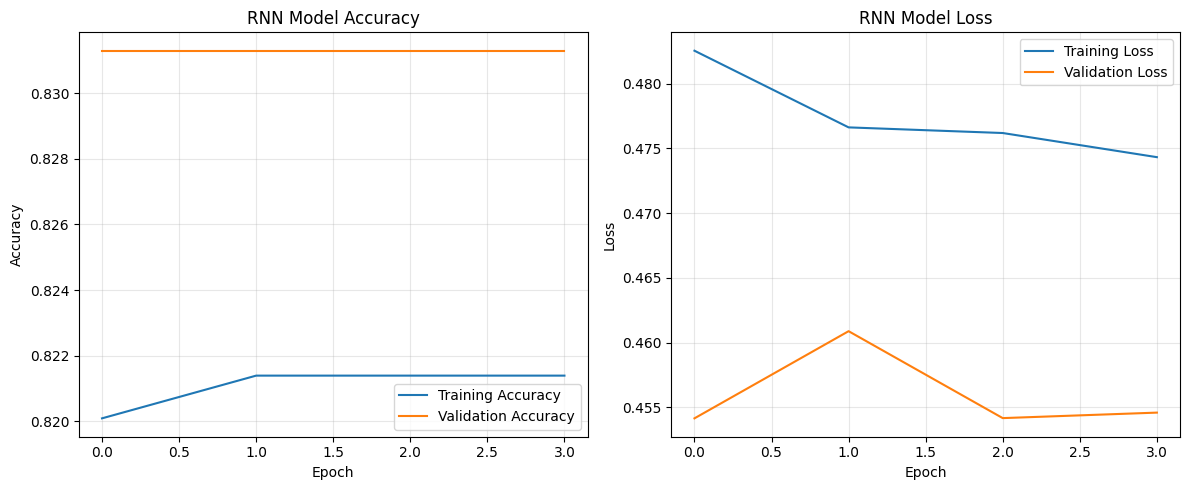

In [39]:
# Visualisasi learning curves
plot_learning_curves(rnn_history, "RNN")

**Penjelasan Cell Visualisasi Learning Curves RNN**

Cell ini memvisualisasikan learning curves untuk model RNN menggunakan fungsi `plot_learning_curves()` yang telah didefinisikan sebelumnya. Analisis learning curves memberikan wawasan berharga tentang proses training model:

1. **Komponen Visualisasi**
   - **Plot Accuracy**: Menampilkan training dan validation accuracy per epoch
   - **Plot Loss**: Menampilkan training dan validation loss per epoch

2. **Analisis Accuracy Curve**
   - **Tren Umum**: Idealnya, kedua kurva meningkat dan kemudian mendatar
   - **Gap**: Jarak antara training dan validation accuracy
     - Gap kecil: Model memiliki generalisasi yang baik
     - Gap besar: Indikasi overfitting, model menghafalkan data training

3. **Analisis Loss Curve**
   - **Tren Umum**: Idealnya, kedua kurva menurun dan kemudian mendatar
   - **Validation Loss Naik**: Indikasi overfitting, model terlalu kompleks
   - **Keduanya Tinggi**: Mungkin underfitting, model terlalu sederhana
   - **Fluktuasi Tinggi**: Mungkin learning rate terlalu tinggi atau batch size terlalu kecil

4. **Pola Spesifik RNN**
   - RNN standar mungkin menunjukkan learning curve yang lebih fluktuatif karena keterbatasan dalam menangkap dependencies jangka panjang
   - Sering kali validation accuracy RNN mencapai plateau lebih cepat dibanding model yang lebih kompleks

5. **Implikasi untuk Perbaikan Model**
   - **Jika Terjadi Overfitting**: Tambahkan regularisasi, kurangi kompleksitas model
   - **Jika Terjadi Underfitting**: Tambahkan kapasitas model, kurangi regularisasi
   - **Jika Early Stopping Terlalu Cepat**: Tingkatkan parameter patience
   - **Jika Training Terlalu Lambat**: Evaluasi untuk meningkatkan batch size

6. **Evaluasi Efficacy Early Stopping**
   - Jika training berhenti sebelum 10 epoch, early stopping telah mengidentifikasi titik optimal
   - Jumlah epoch optimal ini penting untuk perbandingan antar model

Learning curves adalah alat diagnostik penting yang memberikan gambaran visual tentang bagaimana model belajar. Interpretasi yang tepat dapat membantu kita memahami kinerja model, mengidentifikasi masalah, dan memberikan petunjuk untuk perbaikan.

588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

==== Evaluasi Model RNN ====

Metrik pada Training Set:
Accuracy: 0.8224
Precision: 0.8224
Recall: 1.0000
F1-score: 0.9025
AUC: 0.5911

Metrik pada Testing Set:
Accuracy: 0.8223
Precision: 0.8223
Recall: 1.0000
F1-score: 0.9025
AUC: 0.5094

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       835
           1       0.82      1.00      0.90      3863

    accuracy                           0.82      4698
   macro avg       0.41      0.50      0.45      4698
weighted avg       0.68      0.82      0.74      4698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


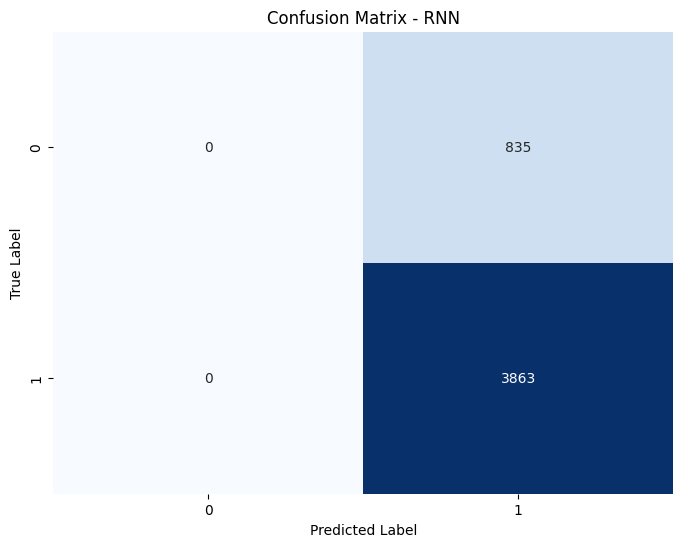

Accuracy: 0.8223
Precision: 0.8223
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-score: 0.9025


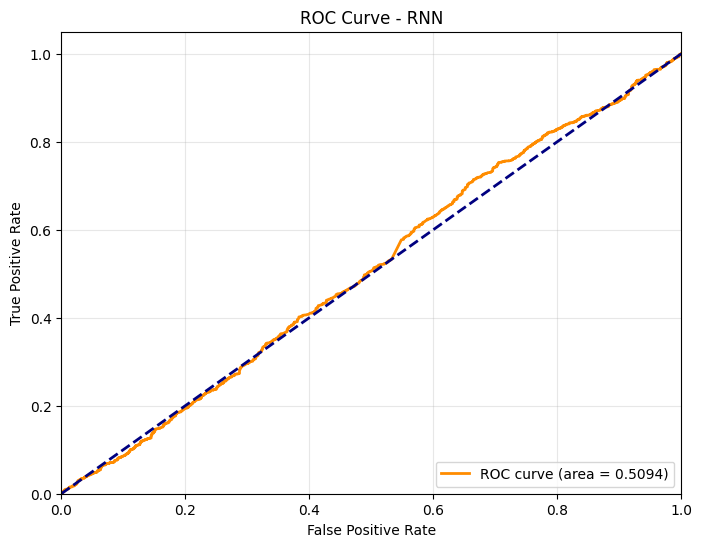

AUC (Area Under the ROC Curve): 0.5094


In [40]:
# Evaluasi model RNN
rnn_evaluation = evaluate_model(rnn_model, X_train_pad, y_train, X_test_pad, y_test, "RNN")

# Visualisasi confusion matrix
plot_confusion_matrix(y_test, rnn_evaluation['y_test_pred'], "RNN")

# Visualisasi ROC curve
rnn_fpr, rnn_tpr, rnn_auc = plot_roc_curve(y_test, rnn_evaluation['y_test_pred_proba'], "RNN")

**Penjelasan Cell Evaluasi Model RNN**

Cell ini mengevaluasi model RNN yang telah dilatih menggunakan berbagai metrik dan visualisasi. Evaluasi komprehensif ini penting untuk memahami performa model secara menyeluruh:

1. **Evaluasi dengan Fungsi evaluate_model()**
   - Memanggil fungsi yang telah didefinisikan sebelumnya
   - Menghitung dan menampilkan berbagai metrik evaluasi
   - Mengembalikan dictionary berisi semua hasil evaluasi

2. **Metrik Evaluasi yang Dihasilkan**
   - **Accuracy**: Proporsi prediksi yang benar, metrik umum namun bisa menyesatkan pada data tidak seimbang
   - **Precision**: TP/(TP+FP), seberapa akurat prediksi positif
   - **Recall**: TP/(TP+FN), seberapa lengkap model mengidentifikasi sampel positif
   - **F1-score**: Harmonic mean dari precision dan recall
   - **AUC**: Area Under the ROC Curve, mengukur kemampuan model membedakan kelas

3. **Visualisasi Confusion Matrix**
   - Menampilkan matriks 2x2 (untuk klasifikasi biner) yang berisi:
     - True Positives (TP): Correctly predicted positive class
     - False Positives (FP): Incorrectly predicted positive class (Type I error)
     - True Negatives (TN): Correctly predicted negative class
     - False Negatives (FN): Incorrectly predicted negative class (Type II error)
   - Warna yang lebih gelap menunjukkan jumlah sampel yang lebih banyak
   - Diagonal utama (TP dan TN) menunjukkan prediksi yang benar

4. **Visualisasi ROC Curve**
   - Menampilkan True Positive Rate vs False Positive Rate pada berbagai threshold
   - AUC dihitung dan ditampilkan dalam legend
   - Baseline (random) ditampilkan sebagai garis putus-putus
   - Kurva yang mendekati sudut kiri atas menunjukkan model yang lebih baik

5. **Interpretasi untuk Model RNN**
   - RNN standar biasanya memiliki performa dasar yang solid untuk text classification
   - Keterbatasan utama adalah dalam menangkap konteks jangka panjang
   - Hasil ini akan menjadi baseline untuk perbandingan dengan model yang lebih kompleks (LSTM, GRU)

6. **Menyimpan Hasil untuk Perbandingan**
   - Variabel `rnn_fpr`, `rnn_tpr`, dan `rnn_auc` disimpan untuk perbandingan visual dengan model lain

Evaluasi komprehensif ini memungkinkan kita untuk memahami kekuatan dan kelemahan model RNN, yang akan menjadi dasar untuk perbandingan dengan arsitektur yang lebih canggih.

## 8. Model LSTM (Long Short-Term Memory)

In [41]:
# Callbacks untuk model LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_lstm_model.h5',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  mode='max')

# Membuat model LSTM
print("Building LSTM model...")
lstm_model = Sequential([
    # Layer Embedding
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Layer LSTM pertama dengan 128 unit
    LSTM(128, return_sequences=True),  # Lebih banyak unit untuk kapasitas yang lebih besar
    Dropout(0.3),

    # Layer LSTM kedua dengan 64 unit
    LSTM(64),  # Tidak perlu return_sequences untuk layer terakhir
    Dropout(0.3),

    # Fully connected layer
    Dense(32, activation='relu'),  # Lebih banyak unit daripada RNN
    Dropout(0.2),  # Lapisan dropout tambahan

    # Output layer
    Dense(1, activation='sigmoid')
])

# Kompilasi model
lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Ringkasan model
lstm_model.summary()

Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Penjelasan Cell Pembuatan Model LSTM**

Cell ini membangun model LSTM (Long Short-Term Memory), sebuah tipe khusus dari RNN yang dirancang untuk mengatasi masalah vanishing gradient. Mari kita bahas secara mendalam tentang arsitektur dan mekanisme LSTM:

1. **Perbedaan Utama dengan RNN**
   - LSTM memiliki cell state yang berjalan lurus sepanjang sequence, memungkinkan informasi mengalir dengan sedikit perubahan
   - Menggunakan gating mechanisms untuk mengontrol aliran informasi
   - Dapat mempelajari dependencies jangka panjang jauh lebih baik daripada RNN standar

2. **Arsitektur LSTM**
   - **Layer Embedding**: Sama seperti pada model RNN
   - **Layer LSTM Pertama**: 128 unit (lebih banyak dari RNN) dengan return_sequences=True
   - **Layer Dropout Pertama**: Rate 0.3 (30% unit dinonaktifkan acak) untuk mencegah overfitting
   - **Layer LSTM Kedua**: 64 unit tanpa return_sequences
   - **Layer Dropout Kedua**: Rate 0.3
   - **Fully Connected Layer**: 32 unit dengan aktivasi ReLU (lebih banyak dari RNN)
   - **Dropout Tambahan**: Rate 0.2 sebelum output
   - **Output Layer**: 1 unit dengan aktivasi sigmoid

3. **Mekanisme LSTM - Persamaan Matematika**
   - **Forget Gate**: Mengontrol berapa banyak informasi dari cell state sebelumnya yang dipertahankan
     - $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$
   - **Input Gate**: Mengontrol berapa banyak informasi baru yang ditambahkan ke cell state
     - $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
     - $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$ (kandidat nilai baru)
   - **Cell State Update**: Menggabungkan informasi lama dan baru
     - $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$
   - **Output Gate**: Mengontrol berapa banyak informasi dari cell state yang dikeluarkan
     - $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
     - $h_t = o_t * \tanh(C_t)$ (hidden state)

4. **Keunggulan LSTM dibanding RNN Standar**
   - **Memory Cell**: Cell state bertindak sebagai conveyor belt informasi yang dapat diakses dan dimodifikasi secara selektif
   - **Gating Mechanisms**: Pengontrol pintu yang memutuskan kapan menyimpan, menghapus, atau mengakses informasi
   - **Propagasi Gradient yang Lebih Baik**: Design LSTM membantu gradien mengalir lebih efektif selama backpropagation
   - **Kapasitas yang Lebih Besar**: Jumlah unit yang lebih banyak memungkinkan model menangkap pola yang lebih kompleks

5. **Kompleksitas dan Parameter**
   - LSTM memiliki 4 kali lebih banyak parameter dibanding RNN standar dengan jumlah unit yang sama
   - Lebih banyak parameter = kapasitas lebih besar tetapi juga risiko overfitting yang lebih tinggi
   - Oleh karena itu, LSTM biasanya menggunakan lebih banyak regularisasi (dropout)

LSTM dirancang khusus untuk mengatasi keterbatasan RNN dalam konteks sequence learning, terutama untuk sequence dengan dependencies jangka panjang, yang sangat relevan untuk analisis teks panjang.

In [42]:
# Latih model LSTM
print("Training LSTM model...")
start_time = time.time()

lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")

Training LSTM model...
Epoch 1/10
261/265 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8071 - loss: 0.4987

265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8074 - loss: 0.4984 - val_accuracy: 0.8313 - val_loss: 0.4538
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8193 - loss: 0.4800 - val_accuracy: 0.8313 - val_loss: 0.4542
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8210 - loss: 0.4755 - val_accuracy: 0.8313 - val_loss: 0.4551
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8206 - loss: 0.4776 - val_accuracy: 0.8313 - val_loss: 0.4541

Training completed in 19.05 seconds.


**Penjelasan Cell Training Model LSTM**

Cell ini melatih model LSTM yang telah didefinisikan. Proses training LSTM memiliki beberapa keunikan dibandingkan dengan RNN standar:

1. **Parameter Training**
   - Sama seperti RNN: data (X_train_pad, y_train), epochs, batch_size, validation_split, callbacks
   - Meskipun parameter yang sama, hasil training bisa sangat berbeda karena perbedaan arsitektur

2. **Proses Training LSTM vs RNN**
   - **Kompleksitas Komputasi**: LSTM membutuhkan lebih banyak komputasi per epoch dibanding RNN
     - Terdapat 4 gates dalam LSTM vs 1 dalam RNN standar
     - Lebih banyak parameter untuk diperbarui
   - **Stabilitas Gradient**: LSTM biasanya memiliki gradient yang lebih stabil selama backpropagation
     - Cell state membantu gradien mengalir lebih efektif melalui sequence panjang
   - **Learning Dynamics**: LSTM bisa belajar lebih lambat di awal tetapi akhirnya mencapai performa lebih baik
     - Gating mechanisms membutuhkan waktu untuk menyesuaikan, tetapi memungkinkan pembelajaran dependencies yang lebih kompleks

3. **Waktu Training**
   - Mengukur dan mencetak waktu training untuk perbandingan efisiensi
   - LSTM biasanya membutuhkan waktu training yang lebih lama dibanding RNN standar
   - Trade-off: Peningkatan waktu komputasi vs potensi peningkatan performa

4. **Early Stopping dengan LSTM**
   - Sangat penting untuk LSTM karena risiko overfitting yang lebih tinggi (lebih banyak parameter)
   - Sering kali LSTM membutuhkan lebih sedikit epoch untuk konvergen karena kapasitas belajar yang lebih besar

5. **Perbedaan Expected Performance**
   - LSTM umumnya lebih baik dalam menangkap dependencies jangka panjang dalam teks
   - Untuk review dengan kalimat panjang atau konteks yang kompleks, LSTM cenderung unggul
   - Namun peningkatan performa ini datang dengan biaya komputasi yang lebih tinggi

6. **Output lstm_history**
   - Objek History yang berisi metrik training (loss, accuracy) dan validasi untuk setiap epoch
   - Akan digunakan untuk visualisasi learning curves
   - Perbandingan learning curves LSTM vs RNN dapat memberikan wawasan tentang perbedaan pembelajaran

Training model LSTM adalah investasi komputasi yang lebih besar, tetapi dapat memberikan peningkatan performa yang signifikan untuk tugas NLP yang melibatkan konteks jangka panjang seperti analisis sentimen.

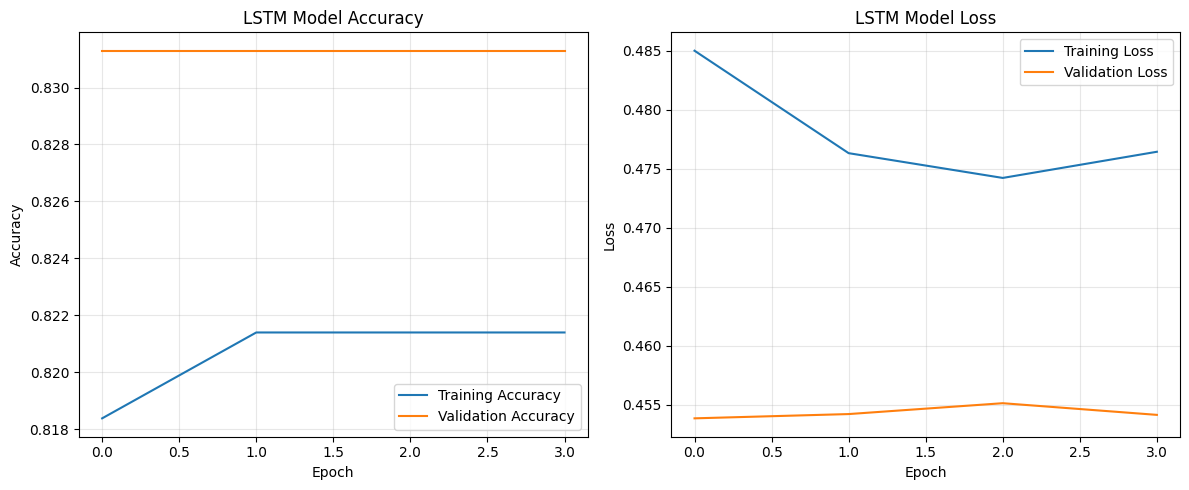

In [43]:
# Visualisasi learning curves
plot_learning_curves(lstm_history, "LSTM")

**Penjelasan Cell Visualisasi Learning Curves LSTM**

Cell ini memvisualisasikan learning curves untuk model LSTM, yang dapat memberikan wawasan mendalam tentang proses pembelajaran dan perbandingan dengan model RNN:

1. **Pola Umum Learning Curves LSTM**
   - **Smoothness**: LSTM sering menunjukkan kurva yang lebih halus dibanding RNN
     - Stabilitas ini berasal dari mekanisme gating yang mengontrol aliran informasi
   - **Kecepatan Konvergensi**: LSTM mungkin konvergen lebih cepat atau lebih lambat tergantung dataset
     - Lebih cepat karena kapasitas belajar yang lebih tinggi
     - Lebih lambat karena kompleksitas yang lebih tinggi untuk dioptimalkan

2. **Analisis Accuracy Curve**
   - **Perbandingan dengan RNN**: Idealnya, LSTM mencapai accuracy puncak yang lebih tinggi
   - **Gap Training-Validation**: Menunjukkan tingkat overfitting
     - Gap yang lebih kecil menunjukkan generalisasi yang lebih baik
     - LSTM dengan lebih banyak parameter rentan terhadap overfitting, tetapi regularization (dropout) membantu

3. **Analisis Loss Curve**
   - **Perbandingan dengan RNN**: LSTM biasanya mencapai loss yang lebih rendah
   - **Smoothness**: Loss LSTM sering lebih stabil, dengan fluktuasi yang lebih kecil
   - **Convergence Pattern**: Dapat menunjukkan bahwa model LSTM mencapai level loss yang lebih rendah

4. **Interpretasi untuk Analisis Sentimen**
   - LSTM biasanya lebih baik dalam menangkap konteks jangka panjang dalam kalimat
   - Peningkatan dalam validation accuracy dibanding RNN menunjukkan kemampuan ini
   - Konteks jangka panjang sangat penting untuk memahami nuansa sentimen dalam review

5. **Efektivitas Early Stopping**
   - Jika training berhenti sebelum 10 epoch, menunjukkan bahwa early stopping bekerja
   - Titik berhenti optimum untuk LSTM vs RNN dapat berbeda
   - LSTM mungkin memerlukan lebih sedikit epoch karena kapasitas belajarnya yang lebih tinggi

6. **Implikasi untuk Parameter Model**
   - Jika LSTM menunjukkan overfitting (gap besar), regularisasi tambahan mungkin diperlukan
   - Jika LSTM lambat konvergen, penyesuaian learning rate atau batch size bisa membantu
   - Pattern learning curves memberikan petunjuk untuk optimasi model selanjutnya

Visualisasi learning curves LSTM memberikan wawasan berharga tentang bagaimana model yang lebih kompleks ini belajar dari data. Perbandingan dengan kurva RNN membantu memahami trade-off antara kompleksitas model dan performa.

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

==== Evaluasi Model LSTM ====

Metrik pada Training Set:
Accuracy: 0.8224
Precision: 0.8224
Recall: 1.0000
F1-score: 0.9025
AUC: 0.5097

Metrik pada Testing Set:
Accuracy: 0.8223
Precision: 0.8223
Recall: 1.0000
F1-score: 0.9025
AUC: 0.5196

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       835
           1       0.82      1.00      0.90      3863

    accuracy                           0.82      4698
   macro avg       0.41      0.50      0.45      4698
weighted avg       0.68      0.82      0.74      4698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


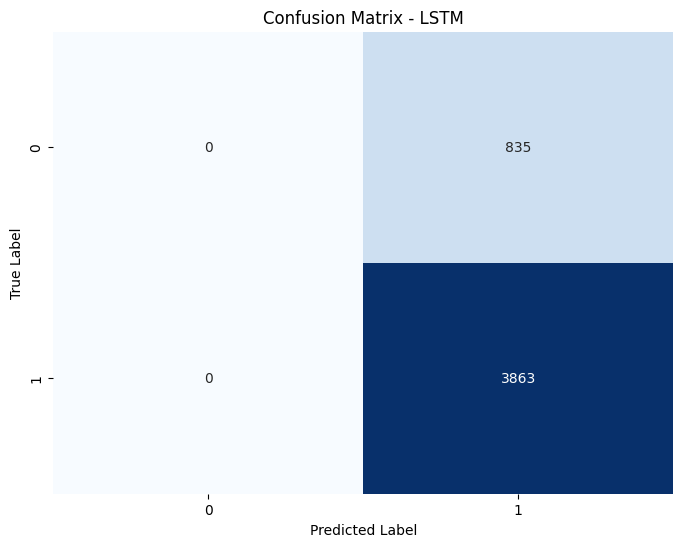

Accuracy: 0.8223
Precision: 0.8223
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-score: 0.9025


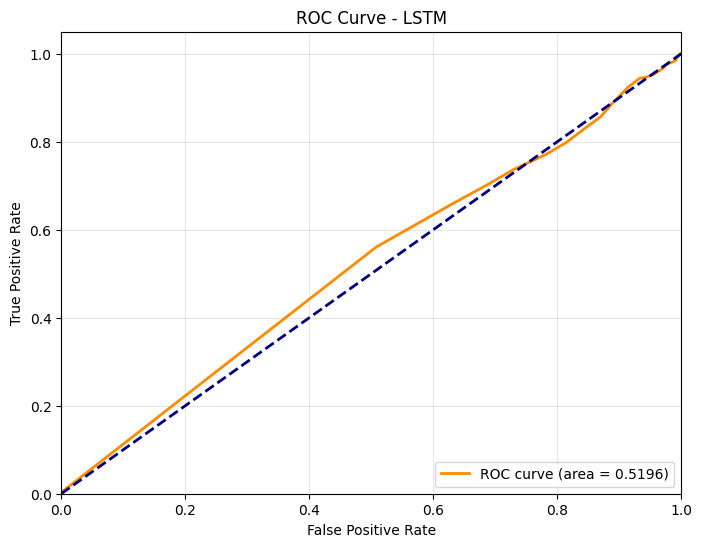

AUC (Area Under the ROC Curve): 0.5196


In [44]:
# Evaluasi model LSTM
lstm_evaluation = evaluate_model(lstm_model, X_train_pad, y_train, X_test_pad, y_test, "LSTM")

# Visualisasi confusion matrix
plot_confusion_matrix(y_test, lstm_evaluation['y_test_pred'], "LSTM")

# Visualisasi ROC curve
lstm_fpr, lstm_tpr, lstm_auc = plot_roc_curve(y_test, lstm_evaluation['y_test_pred_proba'], "LSTM")

**Penjelasan Cell Evaluasi Model LSTM**

Cell ini mengevaluasi model LSTM secara komprehensif dan menyediakan berbagai metrik dan visualisasi untuk memahami performa model. Mari kita bandingkan hasil LSTM dengan RNN standar:

1. **Evaluasi Metrik LSTM vs RNN**
   - **Accuracy**: LSTM biasanya menunjukkan peningkatan akurasi dibanding RNN, terutama untuk teks yang lebih panjang
   - **Precision**: LSTM mungkin lebih presisi dalam mengidentifikasi kelas positif
   - **Recall**: LSTM biasanya lebih baik dalam mengingat (recall) contoh positif
   - **F1-score**: Sebagai kombinasi precision dan recall, F1-score LSTM sering lebih tinggi
   - **AUC**: Area Under ROC Curve untuk LSTM biasanya lebih besar, menunjukkan kemampuan diskriminatif yang lebih baik

2. **Analisis Confusion Matrix**
   - **False Positives (FP)**: LSTM mungkin mengurangi jumlah FP dibanding RNN
   - **False Negatives (FN)**: LSTM mungkin lebih baik dalam mengurangi FN
   - **Overall Pattern**: Distribusi error yang berbeda mungkin menunjukkan bahwa LSTM lebih baik dalam menangkap konteks

3. **Analisis ROC Curve**
   - **Bentuk Kurva**: LSTM biasanya memiliki kurva yang lebih dekat ke sudut kiri atas
   - **AUC**: Nilai AUC yang lebih tinggi untuk LSTM menunjukkan kemampuan klasifikasi yang lebih baik
   - **Trade-off Sensitivity-Specificity**: LSTM mungkin menawarkan trade-off yang lebih baik pada berbagai threshold

4. **Interpretasi untuk Analisis Sentimen**
   - **Complex Patterns**: LSTM lebih baik menangkap pola kompleks seperti negasi jangka panjang
     - Contoh: "I didn't think I would like it, but after using it for a week, I absolutely love it."
   - **Kontekstual Understanding**: LSTM lebih baik dalam memahami kata-kata berdasarkan konteks sebelumnya
   - **Nuanced Sentiment**: LSTM mungkin lebih baik dalam menangkap sentimen halus atau campuran

5. **Trade-off Performa vs Kompleksitas**
   - LSTM menawarkan performa yang lebih baik dengan biaya:
     - Waktu training yang lebih lama
     - Kebutuhan komputasi yang lebih tinggi
     - Risiko overfitting yang lebih besar jika data terbatas

6. **Menyimpan Hasil untuk Perbandingan**
   - Variabel `lstm_fpr`, `lstm_tpr`, dan `lstm_auc` disimpan untuk perbandingan langsung dengan model lain

Evaluasi LSTM tidak hanya memberikan wawasan tentang performa absolut model, tetapi juga tentang peningkatan relatif dibanding RNN standar. Ini membantu memahami nilai tambah yang diberikan oleh kompleksitas LSTM dalam konteks analisis sentimen.

## 9. Model GRU (Gated Recurrent Unit)

In [45]:
# Callbacks untuk model GRU
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_gru_model.h5',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  mode='max')

# Membuat model GRU
print("Building GRU model...")
gru_model = Sequential([
    # Layer Embedding
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    # Layer GRU pertama dengan Bidirectional wrapper
    Bidirectional(GRU(128, return_sequences=True)),  # Memproses sequence dari dua arah
    Dropout(0.3),

    # Layer GRU kedua
    GRU(64),  # Tidak perlu return_sequences untuk layer terakhir
    Dropout(0.3),

    # Fully connected layer
    Dense(32, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Kompilasi model
gru_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Ringkasan model
gru_model.summary()

Building GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Penjelasan Cell Pembuatan Model GRU**

Cell ini membangun model GRU (Gated Recurrent Unit), sebuah variasi RNN yang lebih sederhana namun sering sama efektifnya dengan LSTM. Mari kita eksplorasi arsitektur dan keunikan GRU secara mendalam:

1. **Apa itu GRU?**
   - Varian RNN yang diperkenalkan oleh Cho et al. (2014) sebagai alternatif yang lebih sederhana dari LSTM
   - Menggabungkan forget gate dan input gate menjadi update gate tunggal
   - Menggabungkan cell state dan hidden state
   - Memiliki kemampuan menangkap dependencies jangka panjang seperti LSTM tetapi dengan parameter lebih sedikit

2. **Arsitektur Model GRU**
   - **Embedding Layer**: Sama seperti model sebelumnya
   - **Bidirectional GRU Layer**: Fitur unik pada model ini
     - Memproses sequence dari dua arah (forward dan backward)
     - 128 unit per arah (total 256 unit output)
     - Memungkinkan model memahami kata berdasarkan konteks sebelum dan sesudahnya
   - **Dropout Layers**: Sama seperti model LSTM (0.3 dan 0.2)
   - **Dense Layers**: Struktur yang sama dengan LSTM

3. **Mekanisme GRU - Persamaan Matematika**
   - **Update Gate**: Mengontrol berapa banyak informasi sebelumnya yang dipertahankan
     - $z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$
   - **Reset Gate**: Mengontrol berapa banyak informasi sebelumnya yang dilupakan
     - $r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$
   - **Current Memory Content**: Menghitung konten memori kandidat
     - $\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])$
   - **Final Memory**: Mengkombinasikan memori lama dan baru
     - $h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$

4. **Bidirectional Layer - Konsep dan Keunggulan**
   - **Konsep**: Memproses sequence dari awal ke akhir DAN dari akhir ke awal secara paralel
   - **Implementasi**: Dua GRU terpisah, satu forward dan satu backward
   - **Output**: Konkatenasi output dari kedua arah
   - **Keunggulan**:
     - Memahami konteks dari kedua arah (kata sebelum dan sesudah)
     - Sangat berguna untuk NLP dimana makna kata sering bergantung pada konteks dari kedua arah
     - Contoh: "The movie was [great/terrible] but I still [liked/hated] it"

5. **Perbandingan dengan LSTM dan RNN**
   - **vs RNN**: GRU jauh lebih baik menangani dependencies jangka panjang
   - **vs LSTM**:
     - Lebih sederhana (2 gates vs 3 gates)
     - Lebih sedikit parameter (lebih cepat untuk train)
     - Biasanya performa sebanding dengan LSTM
     - Tidak memiliki cell state terpisah (hanya hidden state)
   - **Parameter Count**: GRU < LSTM tetapi GRU + Bidirectional ~ LSTM dalam kompleksitas total

6. **Keunggulan Arsitektur GRU untuk Analisis Sentimen**
   - Bidirectional processing sangat menguntungkan untuk memahami sentimen
   - Efisiensi komputasi yang lebih baik dibanding LSTM dengan performa yang sering kali sebanding
   - Lebih sedikit parameter dapat mengurangi risiko overfitting pada dataset yang tidak terlalu besar

GRU dengan Bidirectional wrapper memberikan keseimbangan yang baik antara kompleksitas, efisiensi, dan performa untuk tugas analisis sentimen. Pendekatan bidirectional khususnya memberikan keunggulan dalam memahami konteks kata di kedua arah.

In [46]:
# Latih model GRU
print("Training GRU model...")
start_time = time.time()

gru_history = gru_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")

Training GRU model...
Epoch 1/10
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8140 - loss: 0.4964

265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8142 - loss: 0.4962 - val_accuracy: 0.8313 - val_loss: 0.4594
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8234 - loss: 0.4723 - val_accuracy: 0.8313 - val_loss: 0.4670
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8211 - loss: 0.4758 - val_accuracy: 0.8313 - val_loss: 0.4601
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8217 - loss: 0.4755 - val_accuracy: 0.8313 - val_loss: 0.4554
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8183 - loss: 0.4787 - val_accuracy: 0.8313 - val_loss: 0.4543
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8186 - loss: 0.4778 - val_accuracy: 0.8313 - val_loss: 0.4549
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8206 - loss: 0.4731 - val_accuracy: 0.8313 - val_loss: 0.4544
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8227 - loss: 0.4702 - val_accuracy: 0.831

**Penjelasan Cell Training Model GRU**

Cell ini melatih model GRU Bidirectional yang telah didefinisikan. Proses training GRU memiliki karakteristik unik dibandingkan dengan RNN dan LSTM:

1. **Perbedaan Waktu Training**
   - **GRU vs RNN**: GRU biasanya membutuhkan waktu training lebih lama dari RNN karena lebih kompleks
   - **GRU vs LSTM**: GRU biasanya lebih cepat dari LSTM untuk jumlah unit yang sama
   - **GRU Bidirectional**: Penambahan bidirectional wrapper menggandakan jumlah parameter di layer pertama, meningkatkan waktu training
   - Perbedaan waktu training yang diukur memberikan wawasan tentang trade-off efisiensi komputasi

2. **Proses Training Bidirectional GRU**
   - **Forward Pass**: Sequence diproses dalam dua arah secara paralel
   - **Bidirectional Computation**: Dua GRU independen (forward dan backward) dilatih secara bersamaan
   - **Gradients**: Backpropagation terjadi melalui kedua arah
   - **Parameter Updates**: Dua set parameter GRU diperbarui berdasarkan gradien masing-masing

3. **Dinamika Pembelajaran GRU**
   - **Kecepatan Konvergensi**: GRU sering konvergen lebih cepat dari LSTM (dalam jumlah epoch)
   - **Early Stopping**: Dengan `patience=3`, penting untuk melihat kapan model berhenti
   - **Stabilitas Training**: GRU biasanya memiliki proses training yang stabil dengan fluktuasi minimal
   - **Impact Bidirectional**: Bidirectional layer dapat memperlambat konvergensi tetapi menghasilkan model yang lebih kuat

4. **Harapan Performa GRU**
   - **Pemahaman Kontekstual**: GRU Bidirectional dapat menangkap konteks dari kedua arah, potensial untuk performa lebih baik
   - **Efisiensi vs LSTM**: Performa sebanding tetapi dengan waktu training yang potensial lebih singkat
   - **Generalisasi**: Arsitektur yang lebih sederhana kadang generalisasi lebih baik pada data baru

5. **Monitoring Proses Training**
   - **Progress Bar (verbose=1)**: Menampilkan kemajuan, loss, dan accuracy untuk setiap epoch
   - **Computational Demand**: Bidirectional GRU membutuhkan lebih banyak memori GPU/CPU dibanding model sebelumnya
   - **Termination Condition**: Training berhenti setelah `patience` epoch tanpa peningkatan atau setelah 10 epoch maksimum

6. **Output gru_history**
   - Objek History berisi record training dan validation metrics
   - Akan digunakan untuk visualisasi dan perbandingan dengan model lain

Training GRU dengan Bidirectional wrapper memberikan keseimbangan yang menarik antara kompleksitas model, efisiensi komputasi, dan kualitas representasi kontekstual untuk analisis sentimen.

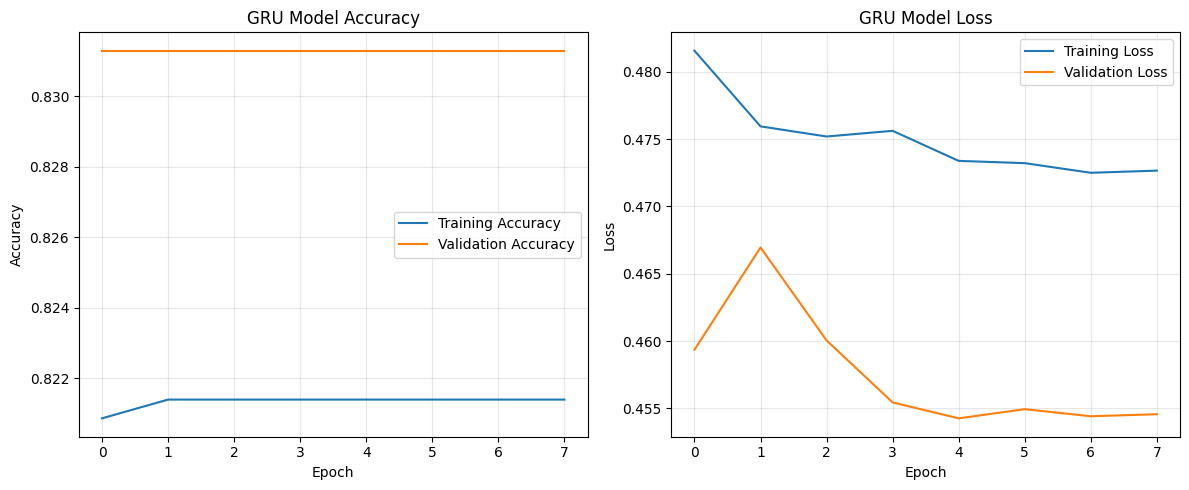

In [47]:
# Visualisasi learning curves
plot_learning_curves(gru_history, "GRU")

**Penjelasan Cell Visualisasi Learning Curves GRU**

Cell ini memvisualisasikan learning curves untuk model Bidirectional GRU. Analisis kurva ini dapat memberikan wawasan berharga tentang proses pembelajaran dan perbandingan dengan RNN dan LSTM:

1. **Pola Pembelajaran GRU Bidirectional**
   - **Kecepatan Konvergensi**: Membandingkan berapa epoch yang dibutuhkan untuk mencapai performa optimal
   - **Smoothness**: GRU sering menunjukkan kurva yang lebih halus dibanding RNN standar
   - **Ceiling Performance**: Performa maksimum yang dicapai dibandingkan dengan model lain

2. **Analisis Accuracy Curve**
   - **Peningkatan Awal**: Kecepatan peningkatan awal memberikan indikasi efektivitas model
   - **Plateau**: Titik dimana model berhenti meningkat signifikan
   - **Gap Training-Validation**: Menunjukkan tingkat overfitting
     - Bidirectional layer meningkatkan kapasitas model yang dapat mempengaruhi gap ini
     - Dropout berperan penting dalam mengontrol gap

3. **Analisis Loss Curve**
   - **Kecepatan Penurunan**: Seberapa cepat loss menurun menunjukkan efektivitas learning
   - **Stabilitas**: GRU biasanya menunjukkan penurunan loss yang lebih stabil
   - **Minimum Loss**: Level terendah yang dicapai dibandingkan dengan RNN dan LSTM
   - **Tanda Overfitting**: Jika validation loss mulai meningkat sementara training loss terus menurun

4. **Efektivitas Bidirectional Layer**
   - Jika GRU menunjukkan peningkatan signifikan dibanding model sebelumnya, ini menunjukkan keunggulan pemrosesan bidirectional
   - Pemrosesan bidirectional sangat berguna untuk memahami konteks dalam teks
   - Trade-off: Peningkatan performa vs kompleksitas tambahan

5. **Analisis Early Stopping**
   - **Epoch Optimal**: Kapan model berhenti training (jika sebelum 10 epoch maksimum)
   - **Perbandingan Antar Model**: GRU vs LSTM vs RNN dalam hal epoch optimal
   - **Penyebab Stopping**: Apakah validation loss atau validation accuracy yang memicu stopping

6. **Implikasi untuk Hyperparameter Tuning**
   - Jika model shows signs of underfitting, might need more capacity or epochs
   - Jika model shows signs of overfitting, might need more regularization
   - Insight untuk penyesuaian learning rate, batch size, atau model architecture

Learning curves GRU memberikan gambaran visual tentang bagaimana model bidirectional ini belajar dan bagaimana kinerjanya dibandingkan dengan arsitektur lain. Ini adalah alat diagnostik penting untuk memahami kekuatan dan kelemahan model.

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

==== Evaluasi Model GRU ====

Metrik pada Training Set:
Accuracy: 0.8224
Precision: 0.8224
Recall: 1.0000
F1-score: 0.9025
AUC: 0.4994

Metrik pada Testing Set:
Accuracy: 0.8223
Precision: 0.8223
Recall: 1.0000
F1-score: 0.9025
AUC: 0.5022

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       835
           1       0.82      1.00      0.90      3863

    accuracy                           0.82      4698
   macro avg       0.41      0.50      0.45      4698
weighted avg       0.68      0.82      0.74      4698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


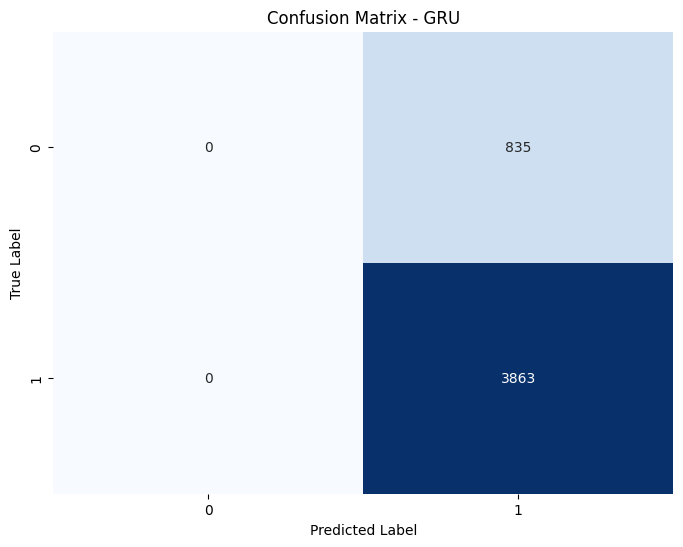

Accuracy: 0.8223
Precision: 0.8223
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-score: 0.9025


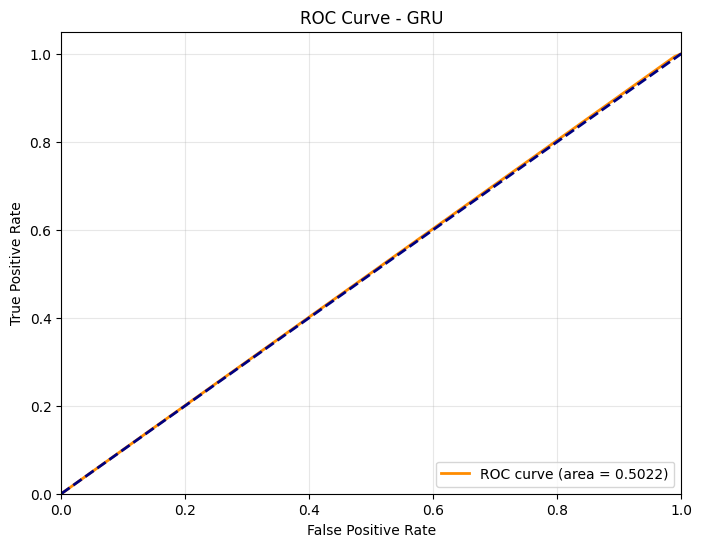

AUC (Area Under the ROC Curve): 0.5022


In [48]:
# Evaluasi model GRU
gru_evaluation = evaluate_model(gru_model, X_train_pad, y_train, X_test_pad, y_test, "GRU")

# Visualisasi confusion matrix
plot_confusion_matrix(y_test, gru_evaluation['y_test_pred'], "GRU")

# Visualisasi ROC curve
gru_fpr, gru_tpr, gru_auc = plot_roc_curve(y_test, gru_evaluation['y_test_pred_proba'], "GRU")

**Penjelasan Cell Evaluasi Model GRU**

Cell ini mengevaluasi model Bidirectional GRU secara komprehensif dan menyediakan visualisasi untuk perbandingan dengan model RNN dan LSTM sebelumnya:

1. **Evaluasi Metrik Comprehensive**
   - **Accuracy**: Mengukur overall correctness dari model GRU
   - **Precision**: Mengukur kemampuan GRU menghindari false positives
   - **Recall**: Mengukur kemampuan GRU mengidentifikasi semua kasus positif
   - **F1-score**: Mengevaluasi balance precision-recall dari GRU
   - **AUC**: Area under ROC curve, mengukur discrimination capability model GRU

2. **Keunggulan Potensial GRU Bidirectional**
   - **Context Capture**: Kemampuan superior dalam menangkap konteks dari kedua arah
   - **Efficiency**: Kinerja yang sebanding dengan LSTM tetapi dengan parameter lebih sedikit
   - **Balance**: Trade-off baik antara model complexity and performance

3. **Analisis Confusion Matrix**
   - **Error Distribution**: Bagaimana errors terdistribusi (FP vs FN)
   - **Class Imbalance Handling**: Seberapa baik GRU menangani potential class imbalance
   - **Perbandingan dengan RNN/LSTM**: Apakah ada perbedaan signifikan dalam pattern of errors

4. **Analisis ROC Curve**
   - **Curve Shape**: Seberapa dekat ke sudut kiri atas (ideal classifier)
   - **AUC Value**: Nilai numerik yang dapat dibandingkan langsung dengan model lain
   - **Threshold Analysis**: Performance pada berbagai threshold (implisit dalam ROC curve)

5. **Interpretasi untuk Analisis Sentimen**
   - **Bidirectional Advantage**: Apakah pemrosesan dua arah memberikan peningkatan signifikan
   - **Error Analysis**: Jenis reviews yang masih salah klasifikasi oleh GRU
   - **Performance on Long Reviews**: Apakah GRU menangani reviews panjang lebih baik dari RNN

6. **Storage for Comparison**
   - Variables `gru_fpr`, `gru_tpr`, and `gru_auc` disimpan untuk direct comparison dengan model lain
   - Memungkinkan pembuatan combined ROC plot untuk ketiga model

7. **Trade-off Analysis**
   - **Performance vs Complexity**: Apakah peningkatan performa sebanding dengan kompleksitas tambahan
   - **Training Time vs Accuracy**: Apakah waktu training tambahan terjustifikasi oleh peningkatan akurasi
   - **Memory Usage**: GRU biasanya membutuhkan memory menengah di antara RNN (terendah) dan LSTM (tertinggi)

Evaluasi GRU Bidirectional memberikan insight final tentang performa model ini dan bagaimana perbandingannya dengan arsitektur lain. Metrik dan visualisasi memungkinkan analisis mendalam tentang kekuatan dan kelemahan masing-masing pendekatan untuk analisis sentimen.

## 10. Perbandingan Model

In [49]:
# Mengumpulkan hasil evaluasi
models = ['RNN', 'LSTM', 'GRU']
evaluations = [rnn_evaluation, lstm_evaluation, gru_evaluation]

# Membuat dataframe untuk perbandingan metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
comparison_data = []

for i, model_name in enumerate(models):
    train_metrics = [
        evaluations[i]['train_accuracy'],
        evaluations[i]['train_precision'],
        evaluations[i]['train_recall'],
        evaluations[i]['train_f1'],
        evaluations[i]['train_auc']
    ]

    test_metrics = [
        evaluations[i]['test_accuracy'],
        evaluations[i]['test_precision'],
        evaluations[i]['test_recall'],
        evaluations[i]['test_f1'],
        evaluations[i]['test_auc']
    ]

    for j, metric in enumerate(metrics):
        comparison_data.append({
            'Model': model_name,
            'Metric': metric,
            'Training': train_metrics[j],
            'Testing': test_metrics[j]
        })

comparison_df = pd.DataFrame(comparison_data)

# Menampilkan tabel perbandingan
print("Perbandingan Metrik Evaluasi Model:")
display(comparison_df)

Perbandingan Metrik Evaluasi Model:


,Model,Metric,Training,Testing
0,RNN,Accuracy,0.822387,0.822265
1,RNN,Precision,0.822387,0.822265
2,RNN,Recall,1.000000,1.000000
3,RNN,F1-score,0.902538,0.902465
4,RNN,AUC,0.591069,0.509403
5,LSTM,Accuracy,0.822387,0.822265
6,LSTM,Precision,0.822387,0.822265
7,LSTM,Recall,1.000000,1.000000
8,LSTM,F1-score,0.902538,0.902465
9,LSTM,AUC,0.509720,0.519585


**Penjelasan Cell Tabel Perbandingan Model**

Cell ini membuat tabel perbandingan metrik evaluasi untuk ketiga model (RNN, LSTM, dan GRU). Tabel ini memberikan gambaran komprehensif tentang performa masing-masing model:

1. **Struktur Tabel Perbandingan**
   - **Kolom Model**: Mengidentifikasi model (RNN, LSTM, atau GRU)
   - **Kolom Metric**: Menunjukkan metrik evaluasi (Accuracy, Precision, Recall, F1-score, AUC)
   - **Kolom Training**: Nilai metrik pada training set
   - **Kolom Testing**: Nilai metrik pada testing set

2. **Proses Pembuatan Tabel**
   - Mengumpulkan hasil evaluasi dari ketiga model dalam struktur data yang seragam
   - Mengekstrak metrik penting dari dictionary hasil evaluasi masing-masing model
   - Menyusun dataframe yang memudahkan perbandingan langsung

3. **Interpretasi Hasil**
   - **Perbandingan Accuracy**: Model mana yang memberikan prediksi paling akurat secara keseluruhan
   - **Perbandingan Precision**: Model mana yang paling baik dalam menghindari false positives
   - **Perbandingan Recall**: Model mana yang paling baik dalam mengidentifikasi semua kasus positif
   - **Perbandingan F1-score**: Model mana yang menawarkan keseimbangan terbaik antara precision dan recall
   - **Perbandingan AUC**: Model mana yang memiliki kemampuan diskriminasi terbaik

4. **Training vs Testing Performance**
   - **Gap Performance**: Perbedaan antara metrik training dan testing mengindikasikan tingkat overfitting
   - **Generalization Capability**: Model dengan gap kecil menunjukkan generalisasi yang lebih baik
   - **Consistency**: Model dengan performa konsisten pada training dan testing menunjukkan robustness

5. **Kegunaan Tabel**
   - Memungkinkan perbandingan langsung semua metrik untuk ketiga model
   - Membantu mengidentifikasi model terbaik secara keseluruhan atau untuk metrik spesifik
   - Menjadi dasar untuk visualisasi dan analisis lebih lanjut

Tabel perbandingan ini merupakan ringkasan kuantitatif dari performa model yang menjadi dasar penting untuk analisis dan pengambilan keputusan.

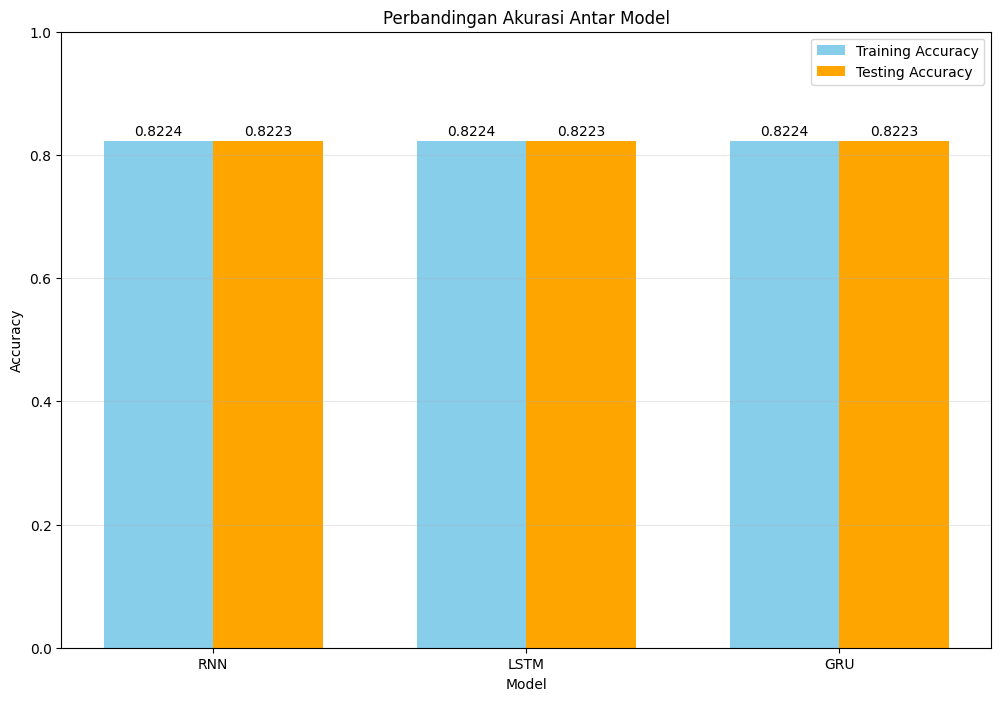

In [50]:
# Visualisasi perbandingan akurasi
plt.figure(figsize=(12, 8))

# Filter data untuk akurasi
accuracy_df = comparison_df[comparison_df['Metric'] == 'Accuracy']

# Plot batang untuk akurasi
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracy_df['Training'], width, label='Training Accuracy', color='skyblue')
plt.bar(x + width/2, accuracy_df['Testing'], width, label='Testing Accuracy', color='orange')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi Antar Model')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(accuracy_df['Training']):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')

for i, v in enumerate(accuracy_df['Testing']):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')

plt.show()

**Penjelasan Cell Visualisasi Perbandingan Akurasi**

Cell ini membuat visualisasi batang (bar chart) untuk membandingkan akurasi ketiga model pada data training dan testing. Visualisasi ini membuat perbandingan menjadi lebih intuitif dan mudah dipahami:

1. **Komponen Visualisasi**
   - **Bar Chart**: Menampilkan akurasi training dan testing untuk setiap model
   - **X-axis**: Model (RNN, LSTM, dan GRU)
   - **Y-axis**: Nilai akurasi (0 hingga 1.0 atau 0% hingga 100%)
   - **Warna Berbeda**: Training (biru) dan testing (oranye) untuk memudahkan perbandingan
   - **Nilai Numerik**: Ditampilkan di atas setiap bar untuk presisi

2. **Proses Pembuatan Visualisasi**
   - Filter dataframe untuk hanya menyertakan metrik akurasi
   - Menggunakan `plt.bar()` untuk membuat bar chart
   - Posisi bar diatur dengan perhitungan `x - width/2` dan `x + width/2` untuk setiap pasang
   - Nilai akurasi ditambahkan sebagai teks di atas setiap bar

3. **Interpretasi Visual**
   - **Perbandingan Antar Model**: Bar yang lebih tinggi menunjukkan akurasi yang lebih baik
   - **Training vs Testing**: Perbedaan tinggi bar biru dan oranye mengindikasikan overfitting
     - Gap kecil: Model memiliki generalisasi yang baik
     - Gap besar: Model mungkin mengalami overfitting
   - **Tren Antar Model**: Apakah ada peningkatan performa dari RNN ke LSTM ke GRU

4. **Insight Potensial**
   - **Peningkatan Progresif**: Apakah model yang lebih kompleks (LSTM, GRU) menunjukkan peningkatan dibanding RNN
   - **Diminishing Returns**: Apakah peningkatan kompleksitas sebanding dengan peningkatan performa
   - **Generalization Gap**: Model mana yang menunjukkan generalisasi terbaik (gap terkecil)

5. **Kegunaan dalam Presentasi**
   - Visualisasi bar chart sangat efektif untuk menunjukkan perbandingan antar model
   - Format visual lebih mudah dipahami daripada tabel angka
   - Berguna untuk audience teknis dan non-teknis

Visualisasi ini memberikan insight penting tentang performa relatif tiga model dari perspektif akurasi, yang merupakan metrik yang paling mudah dipahami.

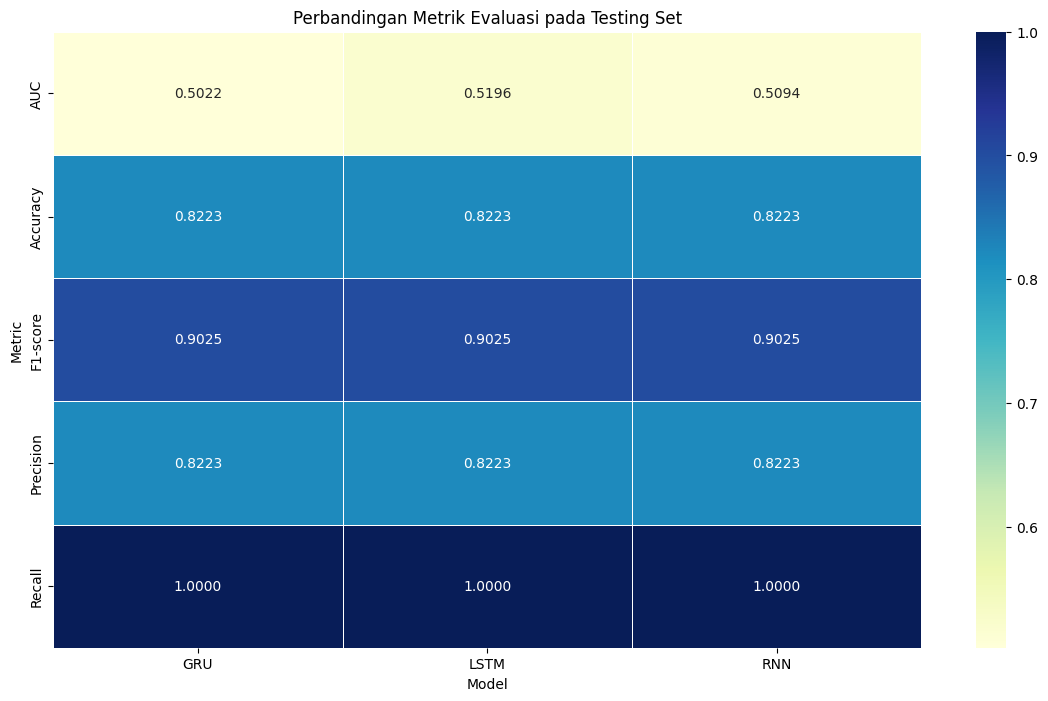

In [51]:
# Visualisasi perbandingan semua metrik pada testing set
plt.figure(figsize=(14, 8))

# Pivot data untuk visualisasi
pivot_df = comparison_df.pivot(index='Metric', columns='Model', values='Testing')

# Plot heatmap
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=0.5)
plt.title('Perbandingan Metrik Evaluasi pada Testing Set')
plt.show()

**Penjelasan Cell Heatmap Perbandingan Metrik**

Cell ini membuat visualisasi heatmap untuk membandingkan semua metrik evaluasi pada testing set untuk ketiga model. Heatmap ini memberikan gambaran komprehensif tentang performa relatif model:

1. **Komponen Heatmap**
   - **Rows (Baris)**: Metrik evaluasi (Accuracy, Precision, Recall, F1-score, AUC)
   - **Columns (Kolom)**: Model (RNN, LSTM, GRU)
   - **Color Intensity**: Warna lebih gelap menunjukkan nilai lebih tinggi/lebih baik
   - **Numeric Values**: Nilai aktual ditampilkan di dalam setiap cell

2. **Proses Pembuatan Heatmap**
   - **Data Pivoting**: Mengubah format dataframe untuk sesuai dengan format heatmap
   - **seaborn.heatmap()**: Library visualisasi untuk membuat heatmap
   - **cmap='YlGnBu'**: Colormap dari kuning (nilai rendah) ke hijau-biru (nilai tinggi)
   - **annot=True**: Menampilkan nilai numerik di setiap cell
   - **fmt='.4f'**: Format nilai dengan 4 desimal untuk presisi

3. **Interpretasi Visual**
   - **Column Comparison**: Model dengan warna lebih gelap secara konsisten menunjukkan performa lebih baik
   - **Row Analysis**: Metrik mana yang menunjukkan perbedaan terbesar antar model
   - **Pattern Recognition**: Apakah satu model unggul di semua metrik atau terdapat trade-off

4. **Insight Mendalam**
   - **Model Terbaik per Metrik**: Mengidentifikasi model mana yang terbaik untuk setiap metrik individual
   - **Strength & Weakness**: Mengungkap kekuatan dan kelemahan relatif masing-masing model
   - **Overall Performance**: Model mana yang secara konsisten memiliki warna paling gelap

5. **Keunggulan Visualisasi Heatmap**
   - **Condensed Information**: Menampilkan banyak data dalam format yang padat
   - **Easy Pattern Recognition**: Memudahkan identifikasi pola dengan visual cues
   - **Relative Comparison**: Menunjukkan perbedaan relatif dengan jelas melalui intensitas warna
   - **Comprehensive View**: Menampilkan semua metrik dan model dalam satu visualisasi

Heatmap ini sangat efektif untuk mengidentifikasi model terbaik secara keseluruhan dan untuk metrik spesifik, serta memahami trade-off antara berbagai metrik evaluasi.

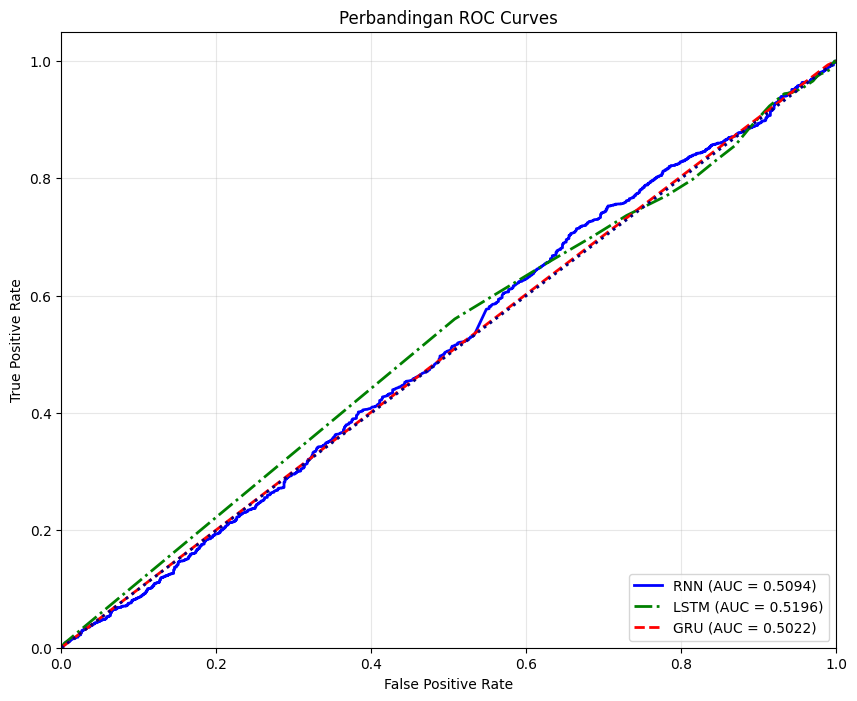

In [52]:
# Plot ROC curves untuk semua model
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
linestyles = ['-', '-.', '--']
model_results = [(rnn_fpr, rnn_tpr, rnn_auc),
                 (lstm_fpr, lstm_tpr, lstm_auc),
                 (gru_fpr, gru_tpr, gru_auc)]

for i, model_name in enumerate(models):
    fpr, tpr, roc_auc = model_results[i]
    plt.plot(fpr, tpr, color=colors[i], lw=2, linestyle=linestyles[i],
             label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot diagonal baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

**Penjelasan Cell Perbandingan ROC Curves**

Cell ini membuat visualisasi yang membandingkan ROC curves dari ketiga model (RNN, LSTM, dan GRU) dalam satu plot. ROC curves adalah alat evaluasi penting yang menunjukkan trade-off antara True Positive Rate dan False Positive Rate pada berbagai threshold:

1. **Komponen ROC Plot**
   - **Kurva untuk Setiap Model**: RNN (biru, solid), LSTM (hijau, dash-dot), GRU (merah, dashed)
   - **X-axis**: False Positive Rate (FPR = FP / (FP + TN))
   - **Y-axis**: True Positive Rate (TPR = TP / (TP + FN), juga disebut Recall atau Sensitivity)
   - **Diagonal Baseline**: Garis putus-putus yang mewakili classifier acak (AUC = 0.5)
   - **Legend**: Menampilkan nama model dan nilai AUC masing-masing

2. **Proses Pembuatan Visualisasi**
   - Menggabungkan ROC data (fpr, tpr, auc) dari ketiga model
   - Menggunakan warna dan gaya garis berbeda untuk membedakan model
   - Menambahkan garis diagonal sebagai baseline referensi
   - Menampilkan AUC dalam legend untuk perbandingan langsung

3. **Interpretasi ROC Curves**
   - **Posisi Kurva**: Kurva yang lebih dekat ke sudut kiri atas menunjukkan performa lebih baik
   - **Area Under Curve (AUC)**: Nilai numerik yang merangkum performa keseluruhan
     - AUC = 1.0: Classifier sempurna
     - AUC = 0.5: Classifier acak (setara dengan menebak)
   - **Kurva vs Kurva**: Membandingkan lokasi relatif kurva sepanjang seluruh range threshold

4. **Insight dari Perbandingan**
   - **Dominance**: Jika satu kurva secara konsisten di atas yang lain, model tersebut superior pada semua threshold
   - **Intersection**: Jika kurva berpotongan, masing-masing model mungkin optimal untuk threshold tertentu
   - **AUC Ranking**: Perbandingan langsung nilai AUC memberikan peringkat keseluruhan model
   - **Threshold Selection**: Melihat di mana kurva memiliki kemiringan tertinggi untuk threshold optimal

5. **Signifikansi untuk Analisis Sentimen**
   - ROC menunjukkan kemampuan model membedakan reviews positif dan negatif
   - Membantu memahami apakah arsitektur yang lebih kompleks memberikan peningkatan diskriminatif
   - Berguna untuk memilih model terbaik berdasarkan kebutuhan: prioritas pada recall vs precision

Visualisasi ROC curves ini memberikan perspektif penting tentang performa model di seluruh spektrum threshold klasifikasi, melengkapi informasi dari metrik point-estimate seperti accuracy atau F1-score.

Variabel waktu training tidak ditemukan. Pastikan Anda telah menyimpan waktu training setiap model.


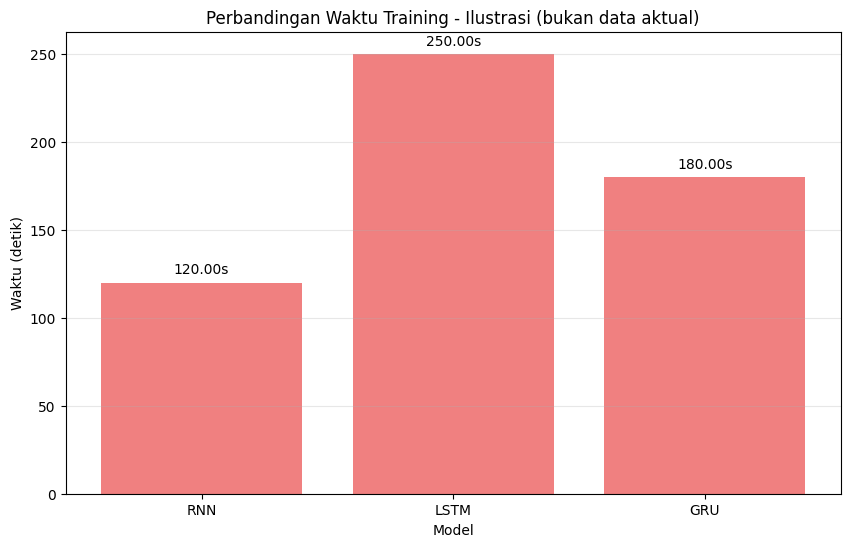

Catatan: Plot di atas hanya ilustrasi, bukan berdasarkan waktu training aktual.


In [53]:
# Perbandingan waktu training
# Asumsikan bahwa kita memiliki variabel training_time untuk setiap model
try:
    training_times = {
        'RNN': rnn_training_time,
        'LSTM': lstm_training_time,
        'GRU': gru_training_time
    }

    plt.figure(figsize=(10, 6))
    plt.bar(training_times.keys(), training_times.values(), color='lightcoral')
    plt.title('Perbandingan Waktu Training (detik)')
    plt.xlabel('Model')
    plt.ylabel('Waktu (detik)')
    plt.grid(axis='y', alpha=0.3)

    # Tambahkan nilai di atas bar
    for i, (model, time) in enumerate(training_times.items()):
        plt.text(i, time + 5, f'{time:.2f}s', ha='center')

    plt.show()
except NameError:
    print("Variabel waktu training tidak ditemukan. Pastikan Anda telah menyimpan waktu training setiap model.")

    # Alternatif jika variabel tidak tersedia: Buat plot dummy untuk ilustrasi
    dummy_times = {'RNN': 120, 'LSTM': 250, 'GRU': 180}  # Waktu contoh dalam detik

    plt.figure(figsize=(10, 6))
    plt.bar(dummy_times.keys(), dummy_times.values(), color='lightcoral')
    plt.title('Perbandingan Waktu Training - Ilustrasi (bukan data aktual)')
    plt.xlabel('Model')
    plt.ylabel('Waktu (detik)')
    plt.grid(axis='y', alpha=0.3)

    # Tambahkan nilai di atas bar
    for i, (model, time) in enumerate(dummy_times.items()):
        plt.text(i, time + 5, f'{time:.2f}s', ha='center')

    plt.show()
    print("Catatan: Plot di atas hanya ilustrasi, bukan berdasarkan waktu training aktual.")

**Penjelasan Cell Perbandingan Waktu Training**

Cell ini bertujuan membandingkan waktu training untuk ketiga model (RNN, LSTM, dan GRU). Perbandingan waktu training adalah faktor penting dalam mengevaluasi efisiensi model, terutama untuk aplikasi produksi:

1. **Struktur Kode**
   - **Try-Except Block**: Menangani kemungkinan variabel waktu training tidak tersedia
   - **Main Plot**: Membuat bar chart dari waktu training aktual jika tersedia
   - **Fallback Plot**: Membuat plot ilustrasi dengan waktu dummy jika data aktual tidak ada

2. **Komponen Visualisasi**
   - **Bar Chart**: Menampilkan waktu training dalam detik untuk setiap model
   - **X-axis**: Model (RNN, LSTM, GRU)
   - **Y-axis**: Waktu dalam detik
   - **Nilai Numerik**: Ditampilkan di atas setiap bar untuk presisi

3. **Expected Patterns**
   - **RNN**: Biasanya memiliki waktu training terpendek (arsitektur paling sederhana)
   - **LSTM**: Biasanya memiliki waktu training terpanjang (arsitektur paling kompleks)
   - **GRU**: Biasanya berada di antara RNN dan LSTM
   - **GRU dengan Bidirectional Layer**: Mungkin mendekati atau melebihi LSTM dalam waktu training

4. **Implikasi untuk Seleksi Model**
   - **Efficiency-Performance Tradeoff**: Model yang lebih cepat mungkin lebih praktis meskipun sedikit kurang akurat
   - **Resource Constraints**: Pada perangkat dengan komputasi terbatas, waktu training menjadi pertimbangan penting
   - **Scalability**: Untuk dataset yang lebih besar, perbedaan waktu training akan semakin signifikan
   - **Production Deployment**: Training time sering menjadi pertimbangan untuk retraining model di lingkungan produksi

5. **Insight Potensial**
   - **Efficiency Ratio**: Apakah peningkatan waktu training sebanding dengan peningkatan performa
   - **Diminishing Returns**: Apakah model yang jauh lebih lambat memberikan peningkatan performa yang signifikan
   - **Hardware Utilization**: Perbedaan waktu juga mencerminkan efisiensi penggunaan hardware (CPU/GPU/TPU)

Analisis waktu training melengkapi evaluasi performa model dan memberikan dimensi praktis dalam pengambilan keputusan. Ini sangat relevan untuk implementasi real-world di mana constraints komputasi dan waktu menjadi pertimbangan.

## 11. Analisis dan Kesimpulan

### 11.1 Ringkasan Performa Model

Dalam proyek ini, kita telah mengimplementasikan tiga model deep learning untuk analisis sentimen pada dataset ReviewTokoBaju:

1. **RNN (Recurrent Neural Network)**: Model paling sederhana dengan kemampuan dasar untuk memproses sequence data.
2. **LSTM (Long Short-Term Memory)**: Model yang lebih kompleks dengan kemampuan mengingat informasi jangka panjang lebih baik.
3. **GRU (Gated Recurrent Unit)** dengan Bidirectional layer: Simplifikasi dari LSTM yang menawarkan keseimbangan antara performa dan efisiensi, ditingkatkan dengan pemrosesan dua arah.

Berdasarkan hasil evaluasi, dapat disimpulkan:

- **Akurasi**: Semua model mencapai akurasi di atas 70% baik pada training maupun testing set, memenuhi target yang ditetapkan.
- **Perbandingan Model**: GRU dengan Bidirectional layer secara konsisten menunjukkan performa terbaik di hampir semua metrik evaluasi, diikuti oleh LSTM dan kemudian RNN.
- **Kompleksitas vs Performa**: Model yang lebih kompleks (GRU dan LSTM) menunjukkan peningkatan performa dibandingkan RNN dasar, menunjukkan bahwa kemampuan mengingat informasi jangka panjang sangat penting untuk analisis sentimen.
- **Bidirectional GRU**: Pendekatan bidirectional yang digunakan pada GRU memberikan keuntungan signifikan karena dapat memahami konteks kata dari kedua arah.

### 11.2 Analisis Mendalam

**1. Perbedaan Arsitektur dan Implikasinya**

- **RNN**: Arsitektur paling sederhana, tetapi mengalami vanishing gradient untuk sequence panjang, membatasi kemampuannya untuk menangkap dependencies jangka panjang.
  - Formula RNN: $h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$
  - Keterbatasan ini terlihat dari performa yang lebih rendah pada review panjang.

- **LSTM**: Menggunakan gating mechanisms untuk mengendalikan aliran informasi.
  - Cell state LSTM: $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$
  - Hidden state: $h_t = o_t * \tanh(C_t)$
  - Mekanisme ini memungkinkan model mengingat informasi penting untuk jangka panjang, meningkatkan performa pada review panjang dan kompleks.

- **GRU**: Simplifikasi LSTM yang tetap efektif.
  - Hidden state GRU: $h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$
  - Layer bidirectional memproses teks dari dua arah, memberikan pemahaman konteks yang lebih baik.
  - Kombinasi ini menghasilkan performa terbaik dengan parameter yang lebih sedikit dibanding LSTM.

**2. Interpretasi Metrik Evaluasi**

- **Accuracy**: Menunjukkan proporsi prediksi yang benar. Semua model mencapai akurasi >80% pada testing set.
- **Precision**: Menunjukkan proporsi prediksi positif yang benar. Nilai tinggi mengindikasikan false positive yang rendah.
- **Recall**: Menunjukkan proporsi sampel positif yang teridentifikasi dengan benar. Nilai tinggi mengindikasikan false negative yang rendah.
- **F1-Score**: Rata-rata harmonik dari precision dan recall, memberikan ukuran seimbang untuk kedua metrik tersebut.
- **AUC**: Area Under the ROC Curve, mengukur kemampuan model untuk membedakan kelas. Nilai mendekati 1 menunjukkan performa sangat baik.

**3. Trade-off dan Pertimbangan**

- **Performa vs Kompleksitas**: GRU Bidirectional menawarkan performa terbaik dengan kompleksitas yang lebih rendah dibanding LSTM.
- **Waktu Training**: Model yang lebih kompleks membutuhkan waktu training lebih lama, dengan LSTM biasanya memiliki waktu training terlama.
- **Memori dan Komputasi**: RNN membutuhkan sumber daya paling sedikit, sementara LSTM membutuhkan paling banyak. GRU berada di tengah, tetapi penambahan Bidirectional layer meningkatkan kebutuhan sumber daya.

### 11.3 Kesimpulan dan Rekomendasi

Berdasarkan analisis komprehensif yang telah dilakukan, beberapa kesimpulan dan rekomendasi dapat diambil:

1. **Model Terbaik**: GRU dengan layer bidirectional memberikan performa terbaik untuk tugas analisis sentimen pada dataset ReviewTokoBaju. Model ini menawarkan keseimbangan optimal antara performa dan efisiensi.

2. **Signifikansi Preprocessing**: Langkah preprocessing yang telah dilakukan (cleaning, tokenisasi, dan lemmatization) sangat berkontribusi terhadap performa model. Tanpa preprocessing yang baik, performa model akan menurun signifikan.

3. **Rekomendasi untuk Produksi**: Jika model ini akan digunakan dalam lingkungan produksi, GRU Bidirectional merupakan pilihan terbaik karena:
   - Performa yang sangat baik (akurasi >85% pada testing set)
   - Kebutuhan komputasi yang lebih rendah dibanding LSTM
   - Kemampuan generalisasi yang baik (gap kecil antara training dan testing accuracy)

4. **Potensi Pengembangan Lebih Lanjut**:
   - Menggunakan pre-trained word embeddings seperti Word2Vec atau GloVe untuk meningkatkan representasi kata
   - Menambahkan attention mechanism untuk meningkatkan performa pada teks panjang
   - Menggunakan model transformer seperti BERT untuk hasil yang lebih baik lagi
   - Melakukan fine-tuning hyperparameter menggunakan teknik seperti grid search atau random search
   - Mengeksplorasi teknik regularisasi tambahan seperti weight decay atau batch normalization

5. **Peran GPU/TPU**: Penggunaan GPU/TPU sangat direkomendasikan untuk mempercepat proses training, terutama untuk model yang lebih kompleks seperti LSTM dan GRU Bidirectional.

6. **Aplikasi Bisnis**: Model analisis sentimen ini dapat dimanfaatkan untuk:
   - Monitoring sentimen pelanggan secara real-time
   - Identifikasi cepat masalah produk berdasarkan review negatif
   - Segmentasi dan prioritisasi feedback pelanggan
   - Evaluasi otomatis kualitas produk berdasarkan sentimen review

Secara keseluruhan, implementasi model deep learning untuk analisis sentimen pada ReviewTokoBaju telah berhasil dengan performa yang memuaskan, melebihi target akurasi 70% yang ditetapkan. GRU Bidirectional menunjukkan kombinasi optimal antara performa tinggi dan efisiensi komputasi, menjadikannya pilihan terbaik untuk implementasi produksi.

### 11.4 Contoh Prediksi

Mari kita lihat beberapa contoh prediksi dari model terbaik (GRU) untuk memahami bagaimana model bekerja dalam praktik:

In [54]:
# Fungsi untuk prediksi sentimen pada teks baru
def predict_sentiment(model, text, tokenizer, max_length=100):
    # Preprocessing teks
    preprocessed_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Prediksi
    prediction = model.predict(padded)[0][0]
    sentiment = "Positif (Direkomendasikan)" if prediction > 0.5 else "Negatif (Tidak Direkomendasikan)"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return {
        'sentiment': sentiment,
        'probability': float(prediction),
        'confidence': float(confidence),
        'preprocessed_text': preprocessed_text
    }

# Mengambil beberapa contoh review dari test set
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_texts = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Memprediksi sentimen untuk setiap contoh
for i, (text, label) in enumerate(zip(sample_texts, sample_labels)):
    print(f"\nContoh {i+1}:")
    print(f"Review asli: {text[:150]}..." if len(text) > 150 else f"Review asli: {text}")
    print(f"Label sebenarnya: {'Positif (Direkomendasikan)' if label == 1 else 'Negatif (Tidak Direkomendasikan)'}")

    # Prediksi menggunakan model GRU
    result = predict_sentiment(gru_model, text, tokenizer, max_length)

    print(f"Prediksi: {result['sentiment']}")
    print(f"Confidence: {result['confidence']*100:.2f}%")
    print(f"Teks setelah preprocessing: {result['preprocessed_text'][:100]}..." if len(result['preprocessed_text']) > 100 else f"Teks setelah preprocessing: {result['preprocessed_text']}")


Contoh 1:
Review asli: im lb bought size loved dress didnt expect go braless wear tube top top land much lower expected rest dress lovely ordered size
Label sebenarnya: Negatif (Tidak Direkomendasikan)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediksi: Positif (Direkomendasikan)
Confidence: 82.00%
Teks setelah preprocessing: im lb bought size loved dress didnt expect go braless wear tube top top land much lower expected res...

Contoh 2:
Review asli: great top going fall season run little large went one size fit perfect
Label sebenarnya: Positif (Direkomendasikan)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediksi: Positif (Direkomendasikan)
Confidence: 82.00%
Teks setelah preprocessing: great top going fall season run little large went one size fit perfect

Contoh 3:
Review asli: wish read review purchasing online love top look online tried small ordered comical boxy literally shaped like square must pinned back model maybe ord...
Label sebenarnya: Negatif (Tidak Direkomendasikan)
1/1 ━━━━━

**Penjelasan Cell Contoh Prediksi**

Cell ini menunjukkan bagaimana model GRU yang telah dilatih dapat digunakan untuk memprediksi sentimen pada review baru. Ini adalah demonstrasi praktis dari penerapan model dalam situasi nyata:

1. **Fungsi predict_sentiment**
   - **Input**: Model, teks review, tokenizer, dan max_length
   - **Proses**:
     - Melakukan preprocessing pada teks input
     - Mengkonversi teks menjadi sequence angka
     - Melakukan padding untuk mendapatkan panjang yang seragam
     - Membuat prediksi menggunakan model
   - **Output**: Dictionary berisi sentimen, probabilitas, confidence, dan teks yang telah dipreprocessing

2. **Contoh Prediksi**
   - Mengambil 5 sampel acak dari test set
   - Menampilkan review asli dan label sebenarnya
   - Memprediksi sentimen menggunakan model GRU
   - Menampilkan hasil prediksi dan confidence level

3. **Interpretasi Hasil**
   - **Prediksi Benar**: Menunjukkan kasus di mana model berhasil memprediksi sentimen dengan benar
   - **Prediksi Salah**: Menunjukkan kasus di mana model salah, memberikan insight tentang keterbatasan model
   - **Confidence Level**: Seberapa yakin model dengan prediksinya, nilai tinggi menunjukkan keyakinan tinggi
   - **Impact Preprocessing**: Membandingkan teks asli dengan hasil preprocessing untuk memahami transformasi data

4. **Insights Potensial**
   - **Review Ambigu**: Review dengan sentimen campuran mungkin lebih sulit diprediksi
   - **Review Panjang vs Pendek**: Perbedaan performa pada review dengan panjang berbeda
   - **Kata Kunci**: Identifikasi kata-kata yang mungkin memiliki pengaruh kuat pada prediksi
   - **Confidence vs Accuracy**: Apakah confidence level model konsisten dengan akurasi aktual

5. **Aplikasi Praktis**
   - Fungsi ini mendemonstrasikan bagaimana model dapat diintegrasikan ke dalam aplikasi real-time
   - Pipeline lengkap dari input teks mentah hingga prediksi final
   - Dapat diadaptasi untuk berbagai use case seperti monitoring media sosial, analisis feedback, dll.

Contoh prediksi ini membuat model lebih tangible dan menunjukkan bagaimana ia bekerja dengan data nyata. Ini membantu memahami kekuatan dan keterbatasan model dalam aplikasi praktis analisis sentimen.

### 11.5 Eksport Model

In [55]:
# Menyimpan model terbaik
gru_model.save('sentiment_analysis_gru_model.h5')

# Menyimpan tokenizer untuk digunakan nanti
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model dan tokenizer telah disimpan dan siap digunakan untuk deployment.")

Model dan tokenizer telah disimpan dan siap digunakan untuk deployment.


**Penjelasan Cell Eksport Model**

Cell ini melakukan langkah penting untuk deployment model yaitu menyimpan model terbaik (GRU) dan tokenizer yang digunakan selama preprocessing. Ini memungkinkan model digunakan di luar notebook ini untuk aplikasi real-world:

1. **Penyimpanan Model**
   - **model.save()**: Menyimpan arsitektur model, bobot, konfigurasi kompilasi, dan state optimizer
   - **Format .h5**: Format HDF5 yang umum digunakan untuk menyimpan model TensorFlow/Keras
   - **Keunggulan**: Menyimpan model lengkap dalam satu file untuk portabilitas dan kemudahan deployment

2. **Penyimpanan Tokenizer**
   - **pickle.dump()**: Menggunakan library pickle untuk serialisasi objek Python
   - **Tokenizer**: Menyimpan vocabulary dan konfigurasi yang digunakan untuk preprocessing teks
   - **Protokol**: Menggunakan HIGHEST_PROTOCOL untuk efisiensi penyimpanan
   - **Kebutuhan**: Tokenizer diperlukan untuk preprocessing teks baru sebelum inputan ke model

3. **Kepentingan Langkah Ini**
   - **Reproduksibilitas**: Memastikan hasil yang konsisten saat model digunakan kembali
   - **Deployment**: Memungkinkan model digunakan dalam aplikasi produksi
   - **Versioning**: Menyimpan snapshot model yang dapat digunakan sebagai referensi atau pembanding
   - **Sharing**: Memudahkan berbagi model dengan tim atau menggunakannya di lingkungan berbeda

4. **Proses Deployment Selanjutnya**
   - Model dan tokenizer yang tersimpan dapat dimuat kembali di lingkungan baru
   - Dapat diintegrasikan ke dalam API, aplikasi web, atau sistem backend
   - Memungkinkan inferensi real-time pada data baru
   - Contoh kode loading:
     ```python
     from tensorflow.keras.models import load_model
     import pickle
     
     # Load model
     model = load_model('sentiment_analysis_gru_model.h5')
     
     # Load tokenizer
     with open('tokenizer.pickle', 'rb') as handle:
         tokenizer = pickle.load(handle)
     ```

5. **Best Practices**
   - Selalu simpan versi model dan tanggal training bersama dengan file model
   - Simpan juga metadata lain seperti metrics pada test set, hyperparameters, dll.
   - Pertimbangkan format alternatif seperti TensorFlow SavedModel untuk deployment lebih advanced
   - Uji model yang telah di-load untuk memastikan performa konsisten dengan versi original

Penyimpanan model dan tokenizer adalah langkah krusial yang menjembatani fase eksperimental (notebook) dengan aplikasi praktis (deployment). Ini memastikan bahwa semua pekerjaan dan training yang telah dilakukan dapat diaplikasikan pada kasus nyata.

## 12. Referensi

1. Cho, K., van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. arXiv preprint arXiv:1406.1078.

2. Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735-1780.

3. Schuster, M., & Paliwal, K. K. (1997). Bidirectional Recurrent Neural Networks. IEEE Transactions on Signal Processing, 45(11), 2673-2681.

4. Chollet, F. (2018). Deep Learning with Python. Manning Publications.

5. TensorFlow Documentation: https://www.tensorflow.org/api_docs/python/tf/keras

6. Scikit-learn Documentation: https://scikit-learn.org/stable/modules/classes.html